# <center>**Bioseñales y sistemas**
## <center>**Proyecto final**
#### Diego Florez 
#### Melissa cadavid  
#### Daniel Felipe Soto Duque 

## **Introducción**

El machine learning, ha revolucionado la manera en que las computadoras procesan información y toman decisiones. Se ha convertido en una herramienta fundamental en diversos campos, desde la medicina hasta las finanzas y la industria tecnológica. Este enfoque computacional permite a las máquinas aprender patrones a partir de datos, capacitándolas para realizar una amplia gama de tareas, como clasificación, predicción, reconocimiento de patrones, optimización de procesos, entre otros.

Desde sus inicios, el aprendizaje automático ha experimentado avances significativos gracias al crecimiento exponencial de la cantidad de datos disponibles, el desarrollo de algoritmos más sofisticados y el aumento en la potencia computacional. Estos avances han permitido la aplicación de técnicas de machine learning en una variedad de áreas, como la medicina (diagnóstico médico, análisis de imágenes médicas), la seguridad (detección de fraudes, análisis de riesgos), la industria (optimización de procesos de fabricación, mantenimiento predictivo) y el entretenimiento (recomendación de contenido, reconocimiento de voz).

El proyecto en cuestión se enfoca en la aplicación del aprendizaje automático para clasificar 7 gestos presentes en señales electromiográficas de 8 canales. Este tipo de aplicación es fundamental en el campo de la rehabilitación, donde la capacidad de reconocer y clasificar gestos musculares puede ser crucial para el desarrollo de dispositivos de asistencia y la mejora de la calidad de vida de las personas con discapacidades físicas. Con el uso de algoritmos de machine learning, se busca aprovechar la información contenida en estas señales para identificar y clasificar los gestos con precisión y rapidez.

In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import scipy.signal as signal
from sklearn.model_selection import train_test_split
import seaborn as sns 

In [52]:
import os
import glob
import pandas as pd

# Ruta donde se encuentran los archivos
path = r'C:\Users\Daniel\Downloads\senales\EMG_data_for_gestures-master'

# Inicialización de contador
index = 0

# Diccionario para almacenar los DataFrames
dataframes_dict = {} 

# Itera sobre cada carpeta en la ruta especificada
for folder in os.listdir(path):
    index += 1
    
    # Obtiene la ruta completa de la carpeta actual
    folder_path = os.path.join(path, folder)
    
    # Obtiene una lista de archivos en la carpeta actual
    files = glob.glob(os.path.join(folder_path, '*'))
    
    # Verifica si hay archivos en la carpeta actual
    if len(files) > 0:
        # Obtiene la ruta del primer archivo en la lista
        first_file = files[0]
        
        # Lee el archivo CSV en un DataFrame usando pandas
        df = pd.read_csv(first_file, delimiter="\t")
        
        # Almacena el DataFrame en el diccionario usando el contador como clave
        dataframes_dict[index] = df


In [53]:
import numpy as np

def tkeo(a):
    # Convierte la lista de entrada en un arreglo de numpy
    a = np.array(a)
    
    # Crea un vector del mismo tamaño lleno de ceros
    aTkeo = np.zeros_like(a)  
    
    # Calcula los términos necesarios para el cálculo de TKEO
    i = a[1:-1] * a[1:-1]
    j = a[2:] * a[:-2]
    
    # Calcula la TKEO para los elementos intermedios del arreglo
    aTkeo[1:-1] = i - j  
    
    # Retorna el vector resultante de la TKEO
    return aTkeo


In [54]:
def TKEO_TODOS(df):
    # Copia el DataFrame de entrada para evitar modificar el original
    df_nuevo = df.copy()
    
    # Itera sobre cada canal en el DataFrame (suponiendo que hay 8 canales)
    for i in range(8):
        # Obtiene el arreglo de valores del canal actual
        arreglo = np.array(df_nuevo[f'channel{i+1}'])
        
        # Calcula la TKEO para el canal actual utilizando la función tkeo
        ar_tkeo = tkeo(arreglo)
        
        # Reemplaza los valores del canal actual en el DataFrame con los valores calculados de TKEO
        df_nuevo[f'channel{i+1}'] = ar_tkeo
    
    # Retorna el DataFrame actualizado con los valores de TKEO para cada canal
    return df_nuevo


Periodograma de welch para ver el espectro de potencia de la señal a filtrar

Se optó por realizar un análisis del espectro de potencia de la señal antes y después de aplicar los filtros utilizando el periodograma de Welch. Esta técnica permite visualizar cómo se distribuye la energía de la señal en diferentes frecuencias, lo que ayuda a identificar las frecuencias de interés y el nivel de ruido presente en la señal.

Para definir los parámetros específicos de los filtros, se consideraron las características de la señal y los requisitos de filtrado. Dado que el dispositivo MYO armband tiene una frecuencia de muestreo para EMG de superficie de 200 Hz, se seleccionaron las frecuencias de corte del filtro de acuerdo con esta frecuencia de muestreo. La elección de un pasa altas a 10 Hz y un pasa bajas a 50 Hz, con una banda de atenuación de 10 Hz en ambos casos, se basó en el análisis del espectro de potencia anterior y en la necesidad de eliminar el ruido no deseado y enfocarse en las frecuencias relevantes.

Además, se optó por utilizar filtros tipo FIR para conservar la linealidad en fase que estos filtros ofrecen. La linealidad en fase es crucial en muchas aplicaciones de procesamiento de señales, ya que garantiza que no se produzcan distorsiones temporales en la señal filtrada. Al preservar la linealidad en fase, se asegura que las relaciones temporales entre las diferentes componentes de la señal se mantengan intactas, lo que es especialmente importante en aplicaciones donde la precisión temporal es crítica, como en el análisis de señales biológicas como la electromiografía.

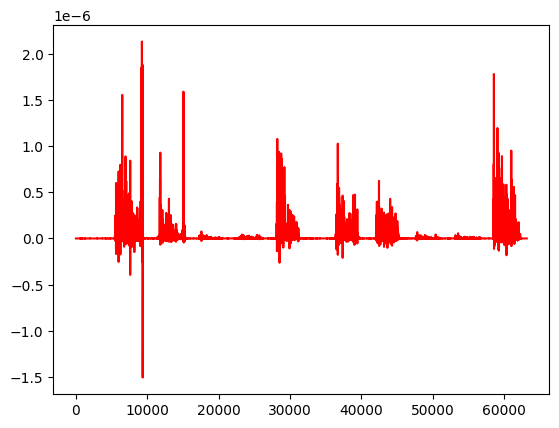

In [55]:
import matplotlib.pyplot as plt

# Aplica la función TKEO_TODOS al primer DataFrame almacenado en dataframes_dict
df_tkeo = TKEO_TODOS(dataframes_dict[1])

# Traza el canal 1 después de aplicar la transformación TKEO en color azul
plt.plot(df_tkeo['channel1'], color='red')
plt.show()  # Muestra el gráfico


In [57]:
fs = 200
orden = 32
wn_baja = 10 / (fs / 2)
wn_alta = 50 / (fs / 2)

# Diseño del filtro pasa bajo (lowpass) FIR
pasaBaja_Fiir = signal.firwin(orden + 1, wn_alta, pass_zero='lowpass', window='hamming')

# Diseño del filtro pasa alta (highpass) FIR
pasaAltas_Fiir = signal.firwin(orden + 1, wn_baja, pass_zero='highpass', window='hamming')


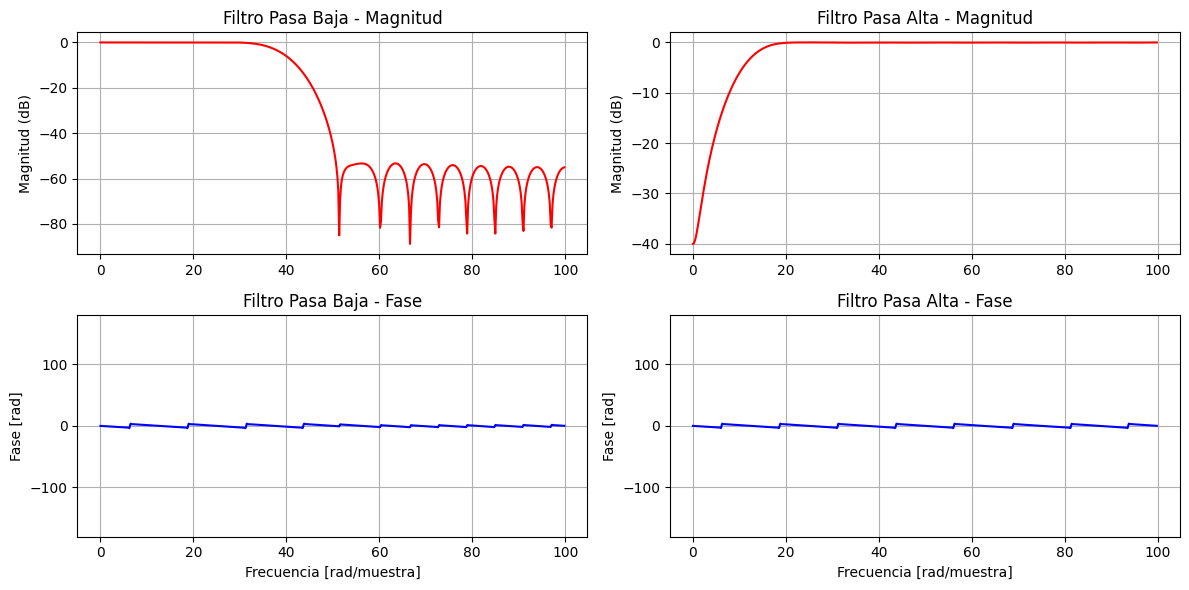

In [58]:
from scipy.interpolate import interp1d

# Calcula la respuesta en frecuencia de los filtros
w_baja, h_baja = signal.freqz(pasaBaja_Fiir, fs=fs)
w_alta, h_alta = signal.freqz(pasaAltas_Fiir, fs=fs)

# Calcula la fase de los filtros
fase_baja = np.angle(h_baja)
fase_alta = np.angle(h_alta)

# Interpola los datos para obtener curvas suavizadas
interp_fase_baja = interp1d(w_baja, fase_baja, kind='cubic')
interp_fase_alta = interp1d(w_alta, fase_alta, kind='cubic')

# Define el rango de frecuencia para la interpolación
w_range_baja = np.linspace(min(w_baja), max(w_baja), 1000)
w_range_alta = np.linspace(min(w_alta), max(w_alta), 1000)

# Configura el tamaño de la figura
plt.figure(figsize=(12, 6))

# Subtrama para el filtro pasa baja (magnitud)
plt.subplot(2, 2, 1)
plt.plot(w_baja, 20 * np.log10(abs(h_baja)), color='red')
plt.title('Filtro Pasa Baja - Magnitud')
plt.ylabel('Magnitud (dB)')
plt.grid(True)

# Subtrama para el filtro pasa baja (fase)
plt.subplot(2, 2, 3)
plt.plot(w_range_baja, interp_fase_baja(w_range_baja), color='blue')
plt.title('Filtro Pasa Baja - Fase')
plt.xlabel('Frecuencia [rad/muestra]')
plt.ylabel('Fase [rad]')
plt.ylim(-180, 180)  # Establece los límites del eje y
plt.grid(True)

# Subtrama para el filtro pasa alta (magnitud)
plt.subplot(2, 2, 2)
plt.plot(w_alta, 20 * np.log10(abs(h_alta)), color='red')
plt.title('Filtro Pasa Alta - Magnitud')
plt.ylabel('Magnitud (dB)')
plt.grid(True)

# Subtrama para el filtro pasa alta (fase)
plt.subplot(2, 2, 4)
plt.plot(w_range_alta, interp_fase_alta(w_range_alta), color='blue')
plt.title('Filtro Pasa Alta - Fase')
plt.xlabel('Frecuencia [rad/muestra]')
plt.ylabel('Fase [rad]')
plt.ylim(-180, 180)  # Establece los límites del eje y
plt.grid(True)

plt.tight_layout()
plt.show()


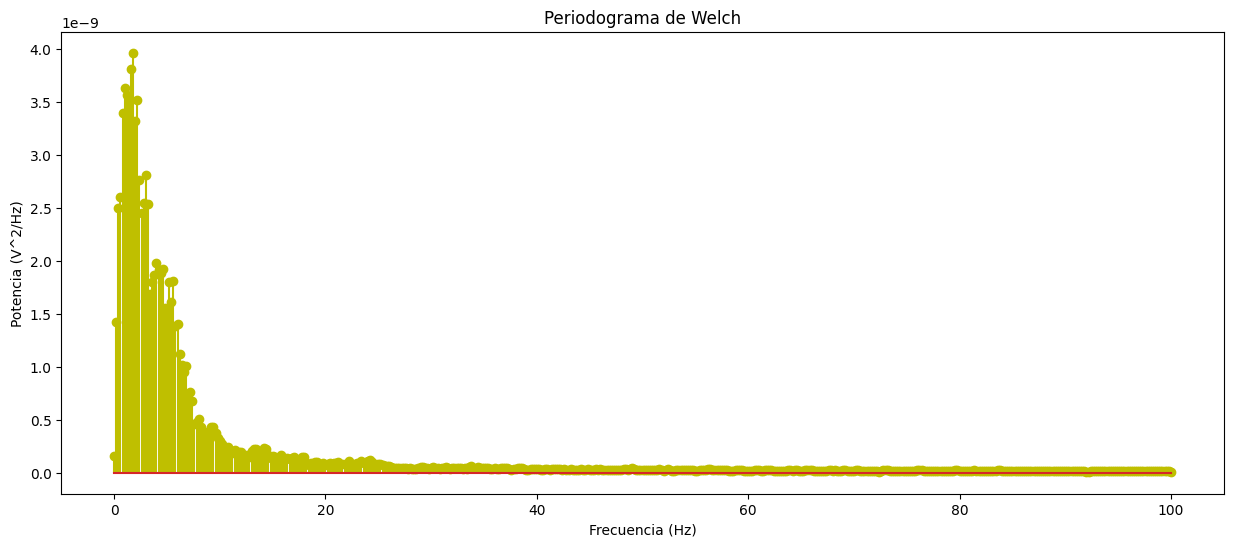

In [90]:
from scipy.signal import welch
from scipy.signal import windows

# Frecuencia de muestreo
fs = 200

# Tamaño de la ventana de 1000 muestras
TV = 1000  

# Solapamiento del 50%
overlap = TV // 2  

# Ventana de Hamming
window = windows.hamming(TV)

# Calcula el periodograma de Welch
f, pxx = welch(dataframes_dict[1]['channel1'], fs=fs, window=window, nperseg=TV, noverlap=overlap)

# Trazado del periodograma de Welch en amarillo
plt.figure(figsize=(15, 6))
plt.stem(f, pxx, linefmt='y')  # Línea amarilla
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Potencia (V^2/Hz)')
plt.title('Periodograma de Welch')
plt.show()



In [60]:
def filt_channels(df):
    # Copia el DataFrame de entrada para evitar modificar el original
    df_nuevo = df.copy()
    
    # Itera sobre cada canal en el DataFrame (suponiendo que hay 8 canales)
    for i in range(8):
        # Obtiene la señal del canal actual como un arreglo de numpy
        senal = np.array(df_nuevo[f'channel{i+1}'])
        
        # Aplica el filtro pasa bajo al canal actual
        signal_filt = signal.filtfilt(b=pasaBaja_Fiir, a=1, x=senal)
        
        # Aplica el filtro pasa alta al canal filtrado por el filtro pasa bajo
        signal_filtt = signal.filtfilt(b=pasaAltas_Fiir, a=1, x=signal_filt)
        
        # Reemplaza los valores del canal actual en el DataFrame con los valores filtrados
        df_nuevo[f'channel{i+1}'] = signal_filtt
    
    # Retorna el DataFrame actualizado con los canales filtrados
    return df_nuevo


In [61]:
# Aplica la función filt_channels al DataFrame df_tkeo
df_filt = filt_channels(df_tkeo)


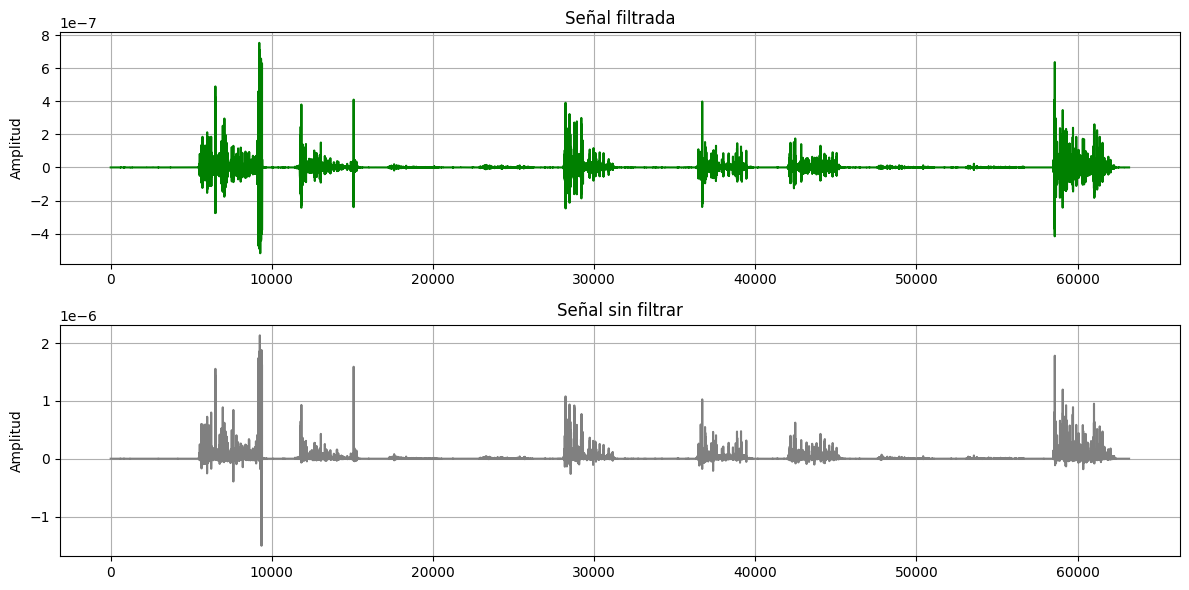

In [65]:
plt.figure(figsize=(12, 6))

# Subtrama para la señal filtrada
plt.subplot(2, 1, 1)
plt.plot(df_filt['channel1'], color='green')
plt.title('Señal filtrada')
plt.ylabel('Amplitud')
plt.grid(True)

# Subtrama para la señal sin filtrar
plt.subplot(2, 1, 2)
plt.plot(df_tkeo['channel1'], color='gray') 
plt.title('Señal sin filtrar')
plt.ylabel('Amplitud')
plt.grid(True)

plt.tight_layout()  # Ajusta el diseño de las subtramas para que no se superpongan
plt.show()  # Muestra el gráfico


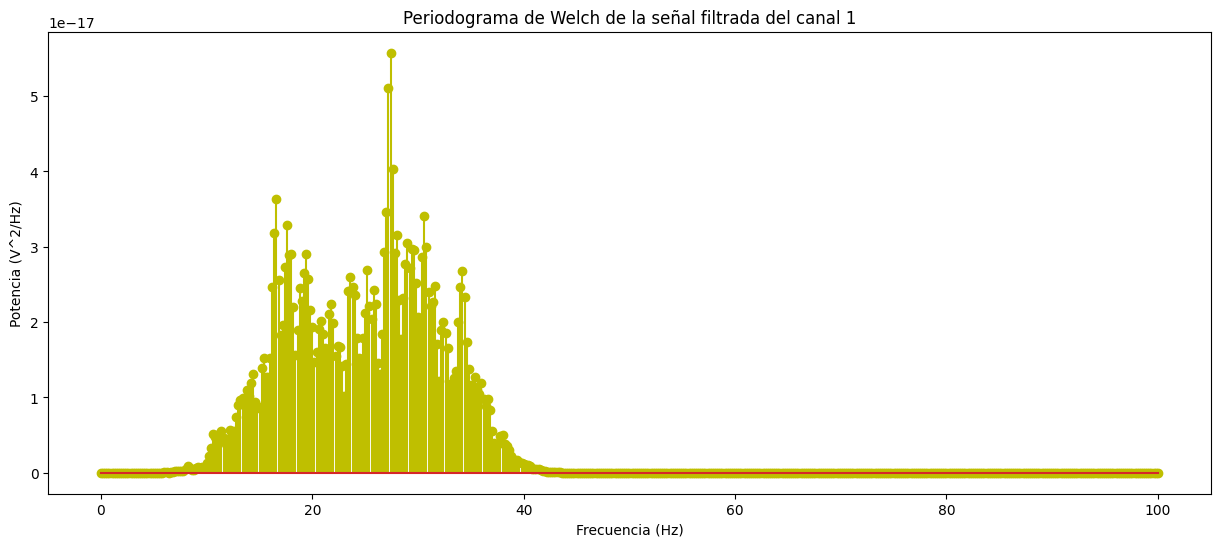

In [66]:
# Calcula el periodograma de Welch de la señal filtrada del canal 1
f, pxx = welch(df_filt['channel1'], fs=fs, window=window, nperseg=window_size, noverlap=overlap)

# Trazado del periodograma de Welch en amarillo
plt.figure(figsize=(15, 6))
plt.stem(f, pxx, linefmt='y')  # Línea amarilla
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Potencia (V^2/Hz)')
plt.title('Periodograma de Welch de la señal filtrada del canal 1')
plt.show()


<Figure size 1200x600 with 0 Axes>

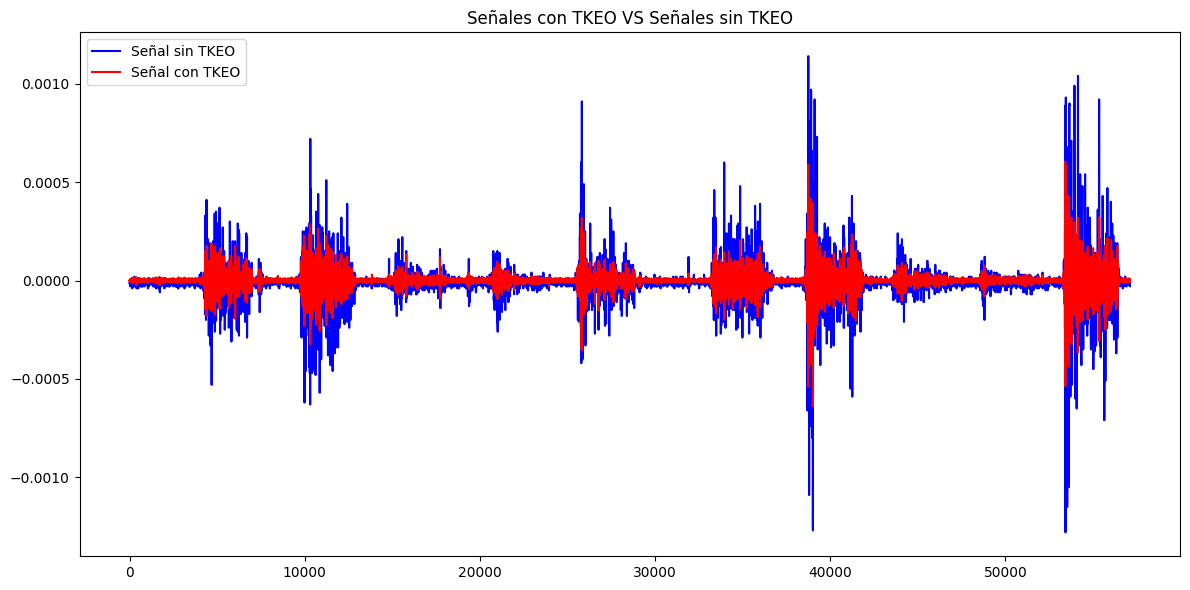

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

In [100]:
# Crea un diccionario para almacenar los datos filtrados con TKEO
DTKEO = {}

# Itera sobre los datos en DTKEO y aplica el filtrado multicanal a cada conjunto de datos
for i, pac in enumerate(dataframes_dict.values(), start=1):
    DTKEO[i] = filt_channels(pac)

# Trazado de las señales con TKEO, sin y con filtrado multicanal
plt.figure(figsize=(12, 6))

# Trazado de las señales con TKEO, sin y con filtrado multicanal
plt.figure(figsize=(12, 6))

# Trazado de la señal sin filtrar y la señal filtrada del canal 1 del conjunto de datos número 5
plt.plot(dataframes_dict[5]['channel1'], color='blue', label='Señal sin TKEO')
plt.plot(DTKEO[5]['channel1'], color='red', label='Señal con TKEO')
plt.title('Señales con TKEO VS Señales sin TKEO')
plt.legend()

plt.tight_layout()
plt.show()
# Trazado de las señales sin y con TKEO para el conjunto de datos número 4
plt.figure(figsize=(10, 8))


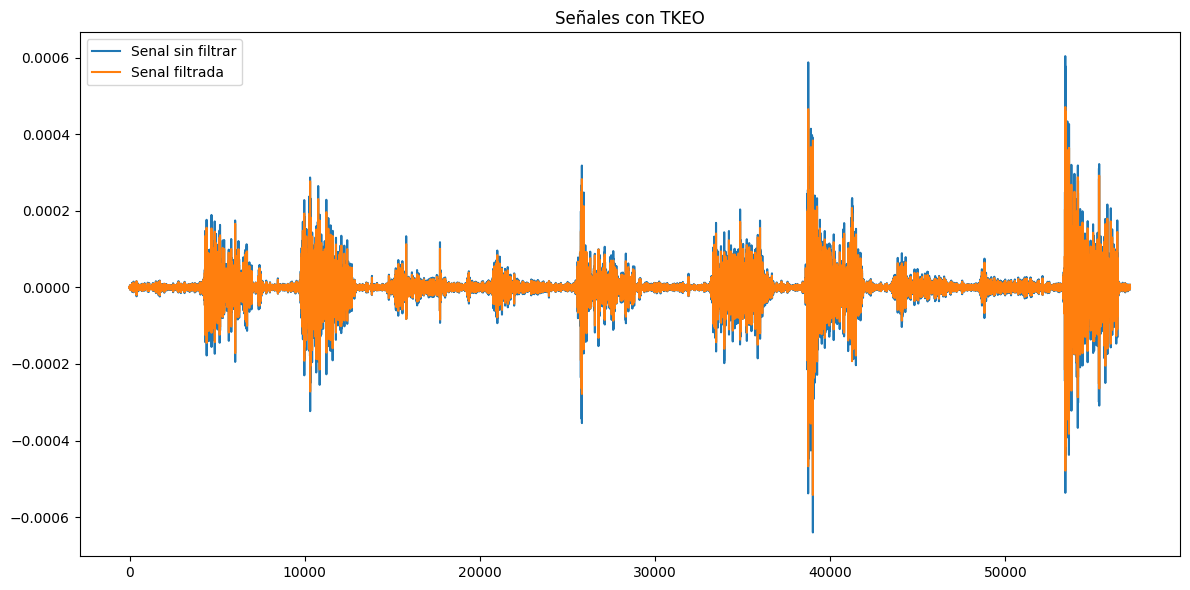

In [101]:

DTKEOFILTERED = {}
i = 0
for pac in DTKEO.values():
    i+=1
    DTKEOFILTERED[i] = filt_channels(pac)

plt.figure(figsize=(12, 6))  

plt.plot(DTKEO[5]['channel1'],label = 'Senal sin filtrar')
plt.plot(DTKEOFILTERED[5]['channel1'], label = 'Senal filtrada')
plt.title('Señales con TKEO')
plt.legend()

plt.tight_layout()



In [102]:
import numpy as np

def calcularRMS(X):
    # Cantidad de puntos en la secuencia
    N = X.size
    # Calcula el cuadrado de cada punto, suma los cuadrados y divide por la cantidad de puntos
    rms = (np.sum(X ** 2) / N) ** 0.5
    return rms


In [103]:
import numpy as np
import pandas as pd

def calculateRMS(signal_array):
    rms = np.sqrt(np.mean(signal_array ** 2))
    return rms

def var_est(df):
    # List to store the results of statistics for each class
    channels_result_list = []
    
    # Names of the statistics to calculate
    statistics = ['class','RMS_1', 'Var_1', 'MAV_1', 'MAVS_1', 'SSC_1', 'WL_1', 'ZC_1',
                  'RMS_2', 'Var_2', 'MAV_2', 'MAVS_2', 'SSC_2', 'WL_2', 'ZC_2',
                  'RMS_3', 'Var_3', 'MAV_3', 'MAVS_3', 'SSC_3', 'WL_3', 'ZC_3',
                  'RMS_4', 'Var_4', 'MAV_4', 'MAVS_4', 'SSC_4', 'WL_4', 'ZC_4',
                  'RMS_5', 'Var_5', 'MAV_5', 'MAVS_5', 'SSC_5', 'WL_5', 'ZC_5',
                  'RMS_6', 'Var_6', 'MAV_6', 'MAVS_6', 'SSC_6', 'WL_6', 'ZC_6',
                  'RMS_7', 'Var_7', 'MAV_7', 'MAVS_7', 'SSC_7', 'WL_7', 'ZC_7',
                  'RMS_8', 'Var_8', 'MAV_8', 'MAVS_8', 'SSC_8', 'WL_8', 'ZC_8']
    
    # Iterate over each class
    for i in range(8):
        # Initialize list with the current class
        class_result = [i]
        
        # List to store the statistics of each channel
        channel_statistics_list = [] 
        
        # Filter data for the current class
        df_class = df[df['class'] == i] 
        
        # Iterate over each channel
        for j in range(8):
            # Get the signal of the current channel as a numpy array
            signal_array = np.array(df_class[f'channel{j+1}'])
            
            # Calculate RMS
            rms = calculateRMS(signal_array)
            
            # Calculate variance
            var = np.var(signal_array)
            
            # Calculate mean absolute value (MAV)
            mean = np.mean(np.abs(signal_array))
            
            # Calculate mean absolute value of the first derivative (MAVS)
            mean_slope = np.mean(np.abs(np.diff(signal_array)))
            
            # Calculate the number of zero crossings of the second derivative (SSC)
            sl_sign_changes = np.sum(np.abs(np.diff(np.sign(np.diff(signal_array)))))
            
            # Calculate the waveform length (WL)
            wl_values = np.sum(np.abs(np.diff(signal_array)))
            
            # Calculate the number of zero crossings (ZC)
            zero_crossings = np.sum(np.diff(np.sign(signal_array)))
            
            # Add the calculated statistics to the list of channel statistics
            channel_statistics = [rms, var, mean, mean_slope, sl_sign_changes, wl_values, zero_crossings]
            channel_statistics_list.extend(channel_statistics)
        
        # Add the statistics of the current class to the results list
        class_result.extend(channel_statistics_list)        
        channels_result_list.append(class_result)
        
    # Create a DataFrame with the calculated statistics
    df_statistics = pd.DataFrame(channels_result_list, columns=statistics)
    return df_statistics


In [79]:
def BFF(diccionario):
    i = 0
    df_final_Tkeo = pd.DataFrame()  # DataFrame final que almacenará todas las estadísticas
    
    # Itera sobre cada conjunto de señales EMG en el diccionario
    for pac in diccionario.values():
        i += 1  # Incrementa el contador de sujetos
        
        # Crea un DataFrame con la columna 'Sujeto' y 'class' para el sujeto actual
        df_np = pd.DataFrame({'Sujeto': (np.ones(8, dtype=int)) * i, 'class': np.arange(0, 8)})
        
        # Calcula las estadísticas para el sujeto actual
        df_final = var_est(pac)
        
        # Combina el DataFrame de sujetos y el DataFrame de estadísticas
        df_final = pd.merge(df_np, df_final, how='left', on='class')
        
        # Concatena el DataFrame actual al DataFrame final
        df_final_Tkeo = pd.concat([df_final_Tkeo, df_final], axis=0)
        
        # Rellena los valores NaN con 0
        df_final_Tkeo = df_final_Tkeo.fillna(0)
    
    return df_final_Tkeo


In [104]:
# Construir el DataFrame final para las señales con TKEO
df_final_Tkeo = BFF(DTKEO)

# Construir el DataFrame final para las señales con TKEO filtradas
df_final_Tkeo_filt = BFF(DTKEOFILTERED)


c:\Users\Daniel\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\Daniel\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\Daniel\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\Daniel\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\Daniel\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.d

El data set nos dice que la etiqueta de los gestos: 0 corresponde a datos no marcados, por lo tanto lo asumimos como ruido para nuestro modelo y decidimos eliminarlo del sistema.

In [106]:
# Define la condición para las filas que se eliminarán
condicion = df_final_Tkeo['class'] == 0

# Elimina las filas que satisfacen la condición
df_final_Tkeo = df_final_Tkeo.drop(index=df_final_Tkeo[condicion].index)

# Muestra el DataFrame resultante
df_final_Tkeo.head()


,Sujeto,class,RMS_1,Var_1,MAV_1,MAVS_1,SSC_1,WL_1,ZC_1,RMS_2,...,SSC_7,WL_7,ZC_7,RMS_8,Var_8,MAV_8,MAVS_8,SSC_8,WL_8,ZC_8
1,1,1,0.000004,1.492379e-11,0.000003,0.000002,2312.0,0.006216,0.0,0.000007,...,2284.0,0.005357,0.0,0.000003,1.176415e-11,0.000002,0.000001,2224.0,0.005426,-2.0
2,1,2,0.000062,3.839420e-09,0.000037,0.000026,2132.0,0.090146,0.0,0.000033,...,2118.0,0.093666,0.0,0.000045,1.982757e-09,0.000028,0.000019,2160.0,0.067458,0.0
3,1,3,0.000049,2.398655e-09,0.000031,0.000020,2300.0,0.076691,2.0,0.000060,...,2322.0,0.033114,-2.0,0.000042,1.786904e-09,0.000026,0.000018,2332.0,0.067587,0.0
4,1,4,0.000014,1.967038e-10,0.000009,0.000006,2082.0,0.020293,2.0,0.000024,...,2086.0,0.044404,2.0,0.000020,3.852175e-10,0.000012,0.000008,2086.0,0.028535,2.0
5,1,5,0.000014,1.904101e-10,0.000009,0.000006,2230.0,0.021046,0.0,0.000032,...,2196.0,0.033370,0.0,0.000014,1.836131e-10,0.000008,0.000006,2198.0,0.020422,0.0


In [108]:
condicion = df_final_Tkeo_filt['class'] == 0
df_final_Tkeo_filt = df_final_Tkeo_filt.drop(index=df_final_Tkeo_filt[condicion].index)
df_final_Tkeo_filt.head()

,Sujeto,class,RMS_1,Var_1,MAV_1,MAVS_1,SSC_1,WL_1,ZC_1,RMS_2,...,SSC_7,WL_7,ZC_7,RMS_8,Var_8,MAV_8,MAVS_8,SSC_8,WL_8,ZC_8
1,1,1,0.000003,1.149419e-11,0.000002,0.000002,2052.0,0.005973,0.0,0.000006,...,2002.0,0.005171,0.0,0.000003,8.833282e-12,0.000002,0.000001,1988.0,0.005227,-2.0
2,1,2,0.000055,3.016769e-09,0.000035,0.000025,1928.0,0.087344,0.0,0.000029,...,1922.0,0.090434,0.0,0.000039,1.514430e-09,0.000026,0.000018,1956.0,0.065114,0.0
3,1,3,0.000043,1.844546e-09,0.000028,0.000019,2062.0,0.073813,0.0,0.000052,...,2110.0,0.031923,0.0,0.000037,1.375287e-09,0.000024,0.000017,2120.0,0.065541,0.0
4,1,4,0.000012,1.491820e-10,0.000008,0.000006,1926.0,0.019544,2.0,0.000021,...,1894.0,0.042777,2.0,0.000017,3.003245e-10,0.000011,0.000008,1910.0,0.027561,2.0
5,1,5,0.000012,1.475701e-10,0.000008,0.000006,2018.0,0.020426,0.0,0.000028,...,2004.0,0.032338,0.0,0.000012,1.436616e-10,0.000008,0.000005,1990.0,0.019805,0.0


Procedemos a revisar la cantidad de uniques en mi columna class y ademas imprimirlos para confirmar que el proceso se realizó de manera efectiva

In [109]:
# Verifica cuántos valores únicos hay en la columna 'class'
num_unique_classes = df_final_Tkeo_filt['class'].nunique()

print("Número de valores únicos en la columna 'class':", num_unique_classes)


Número de valores únicos en la columna 'class': 7


In [110]:
# Verifica cuáles son los valores únicos en la columna 'class'
unique_classes = df_final_Tkeo_filt['class'].unique()

print("Valores únicos en la columna 'class':", unique_classes)


Valores únicos en la columna 'class': [1 2 3 4 5 6 7]


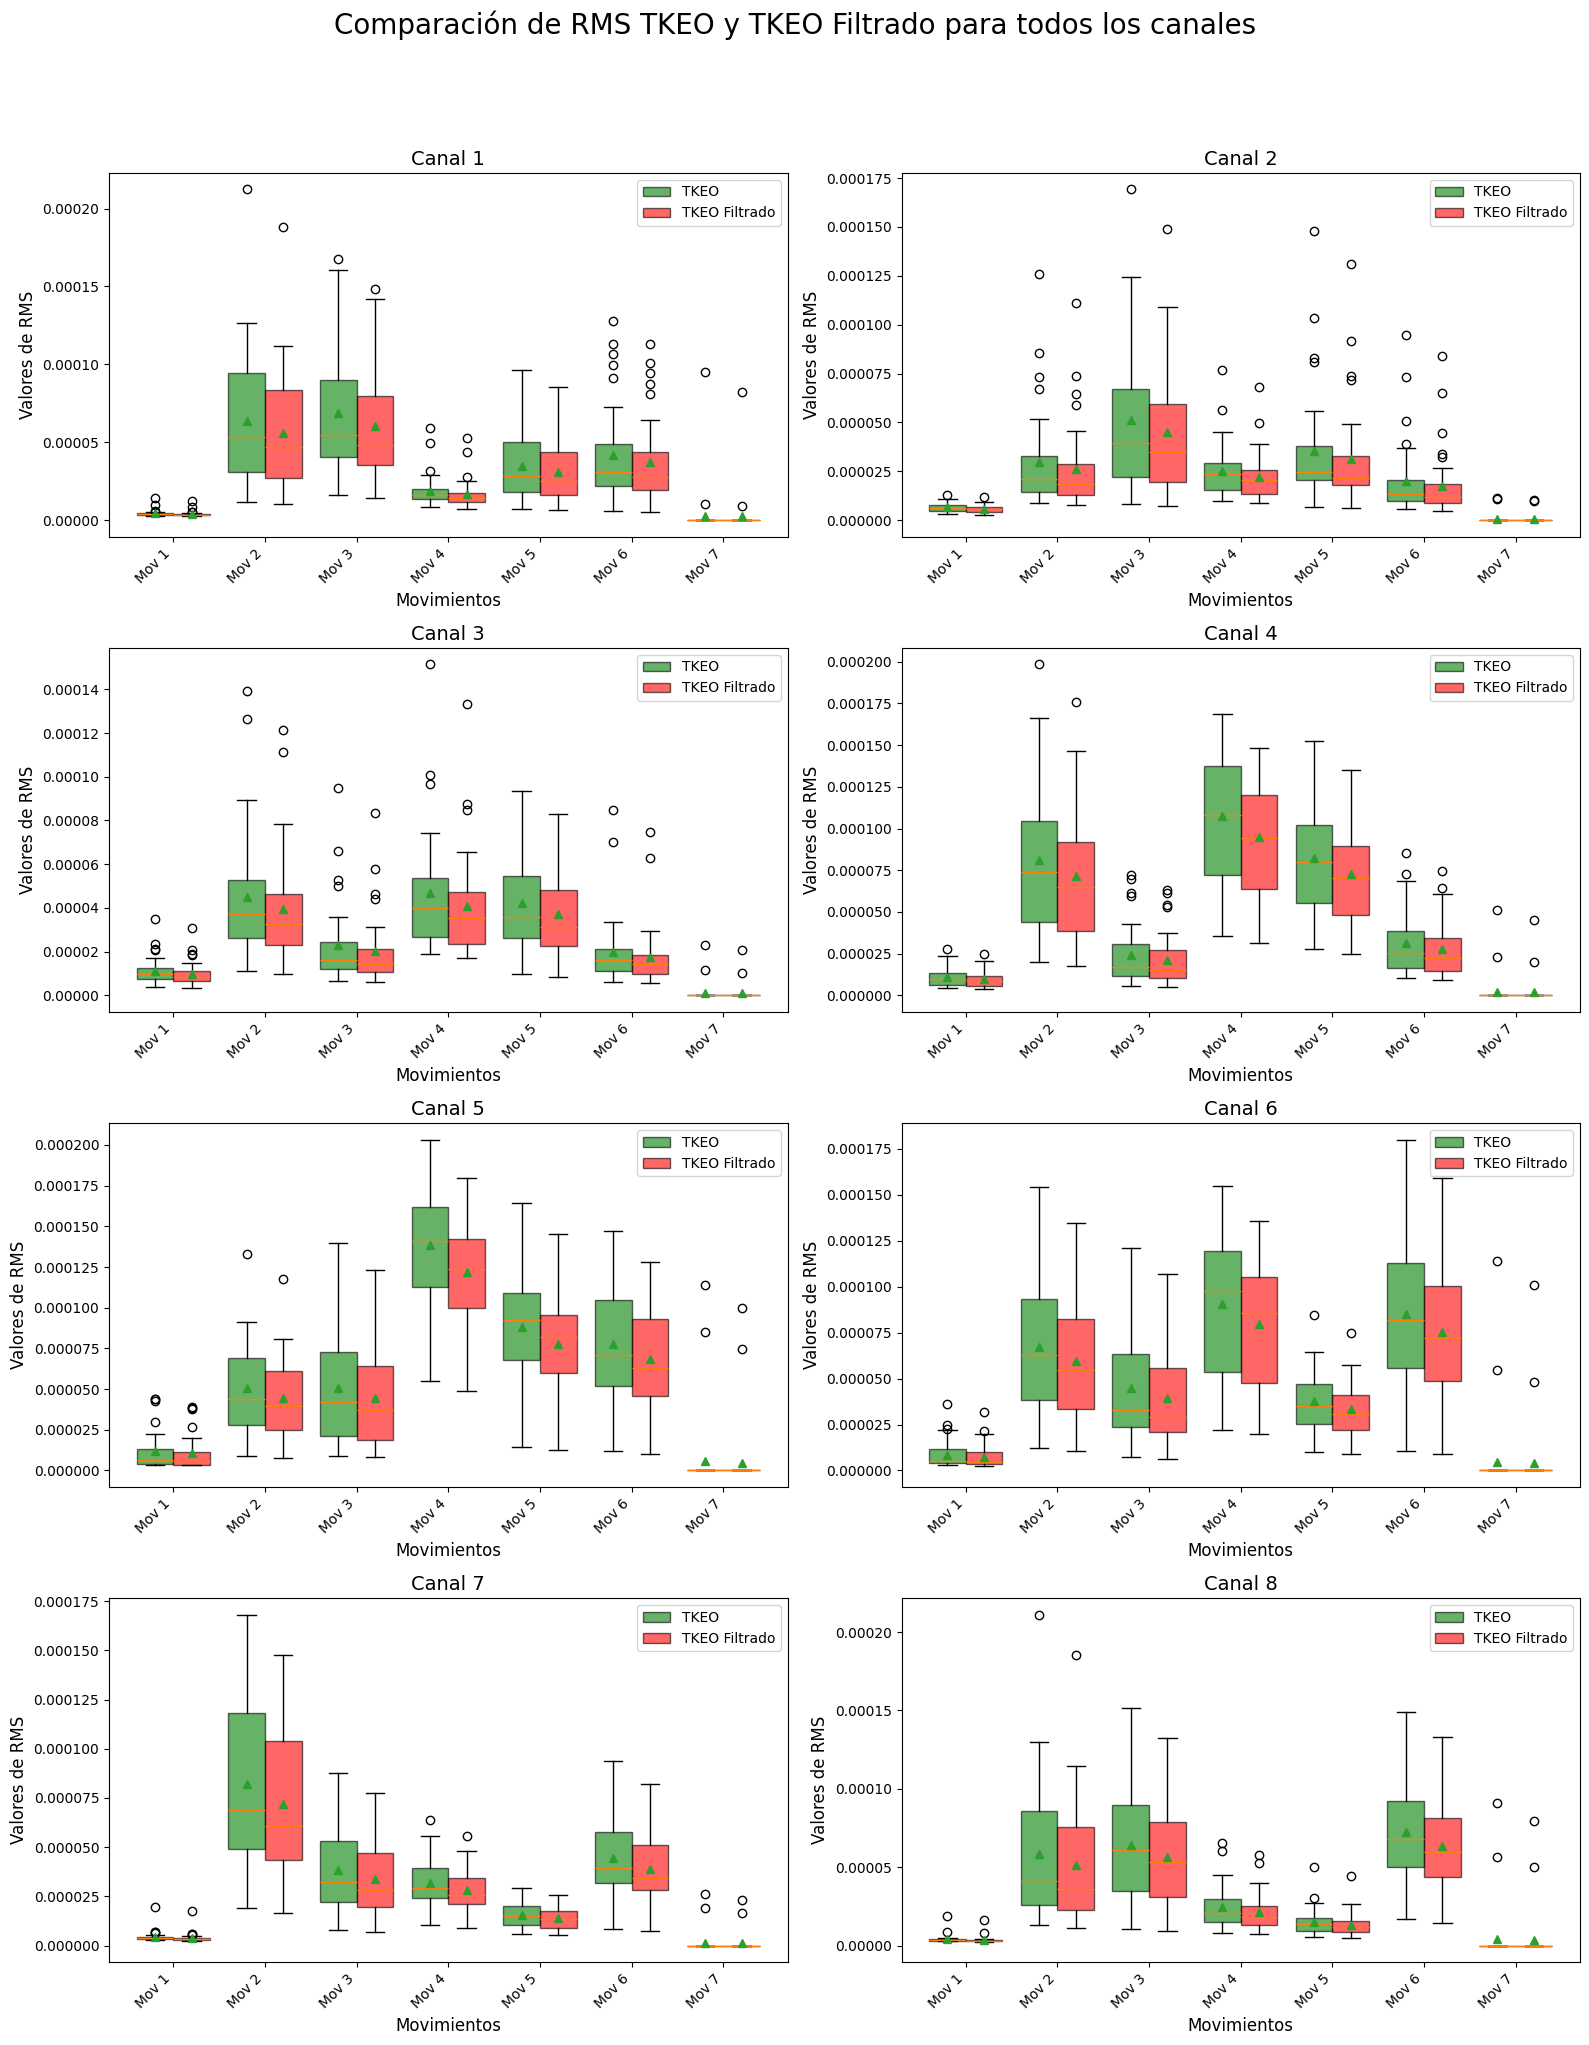

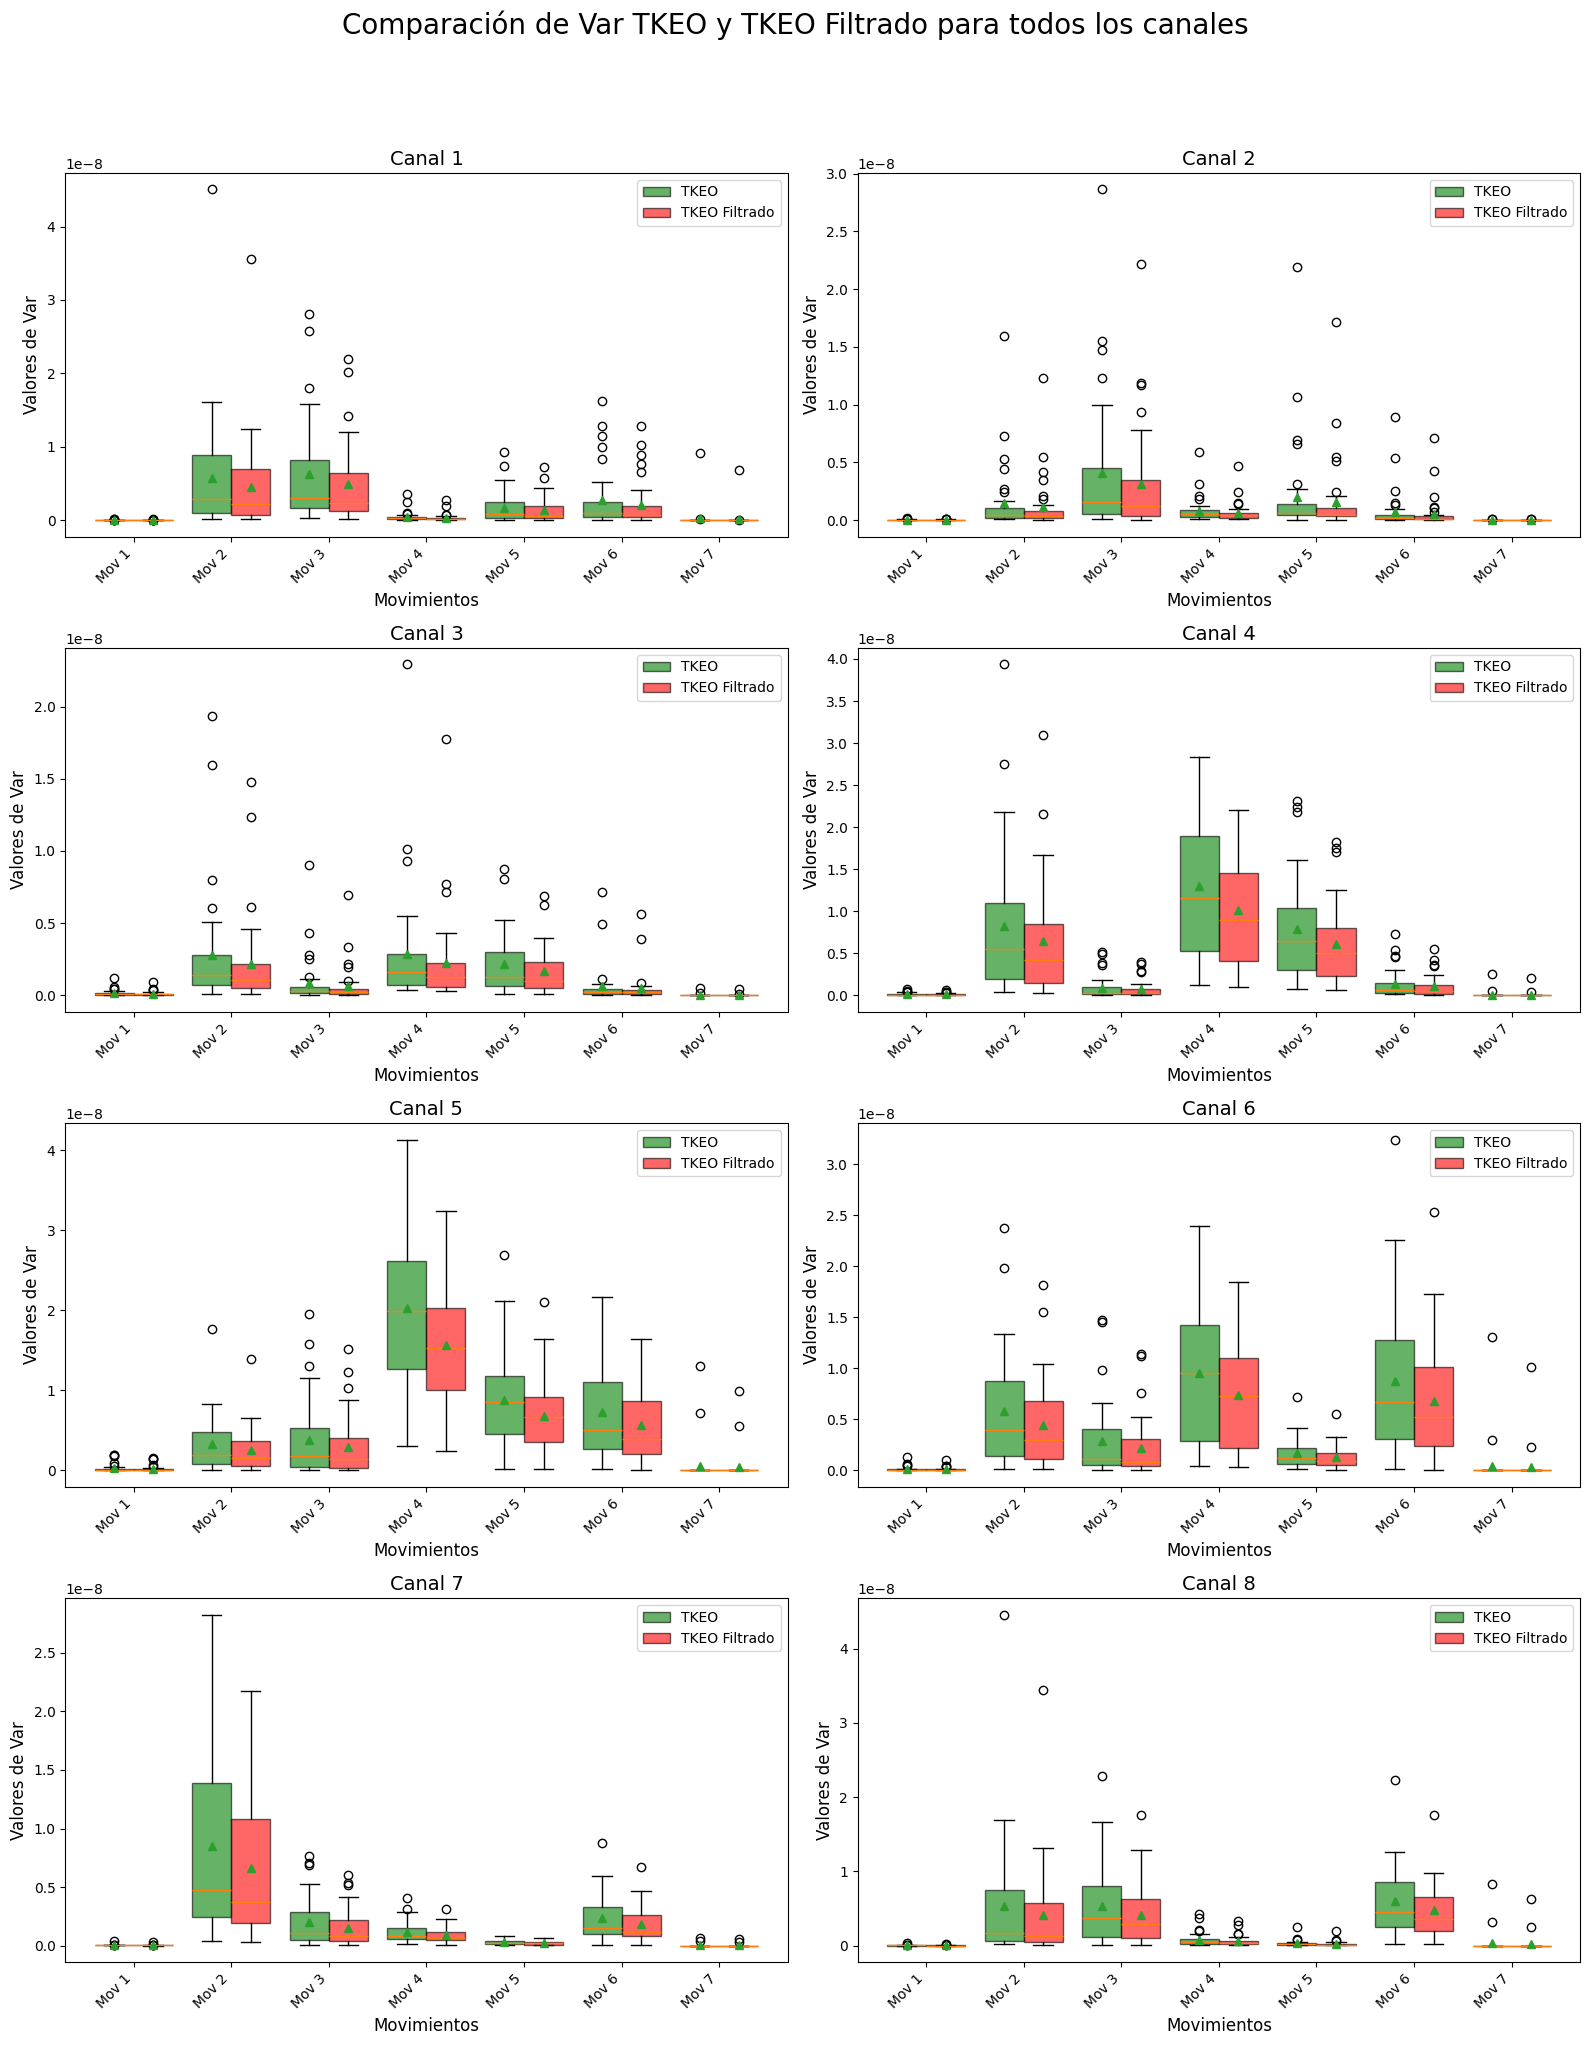

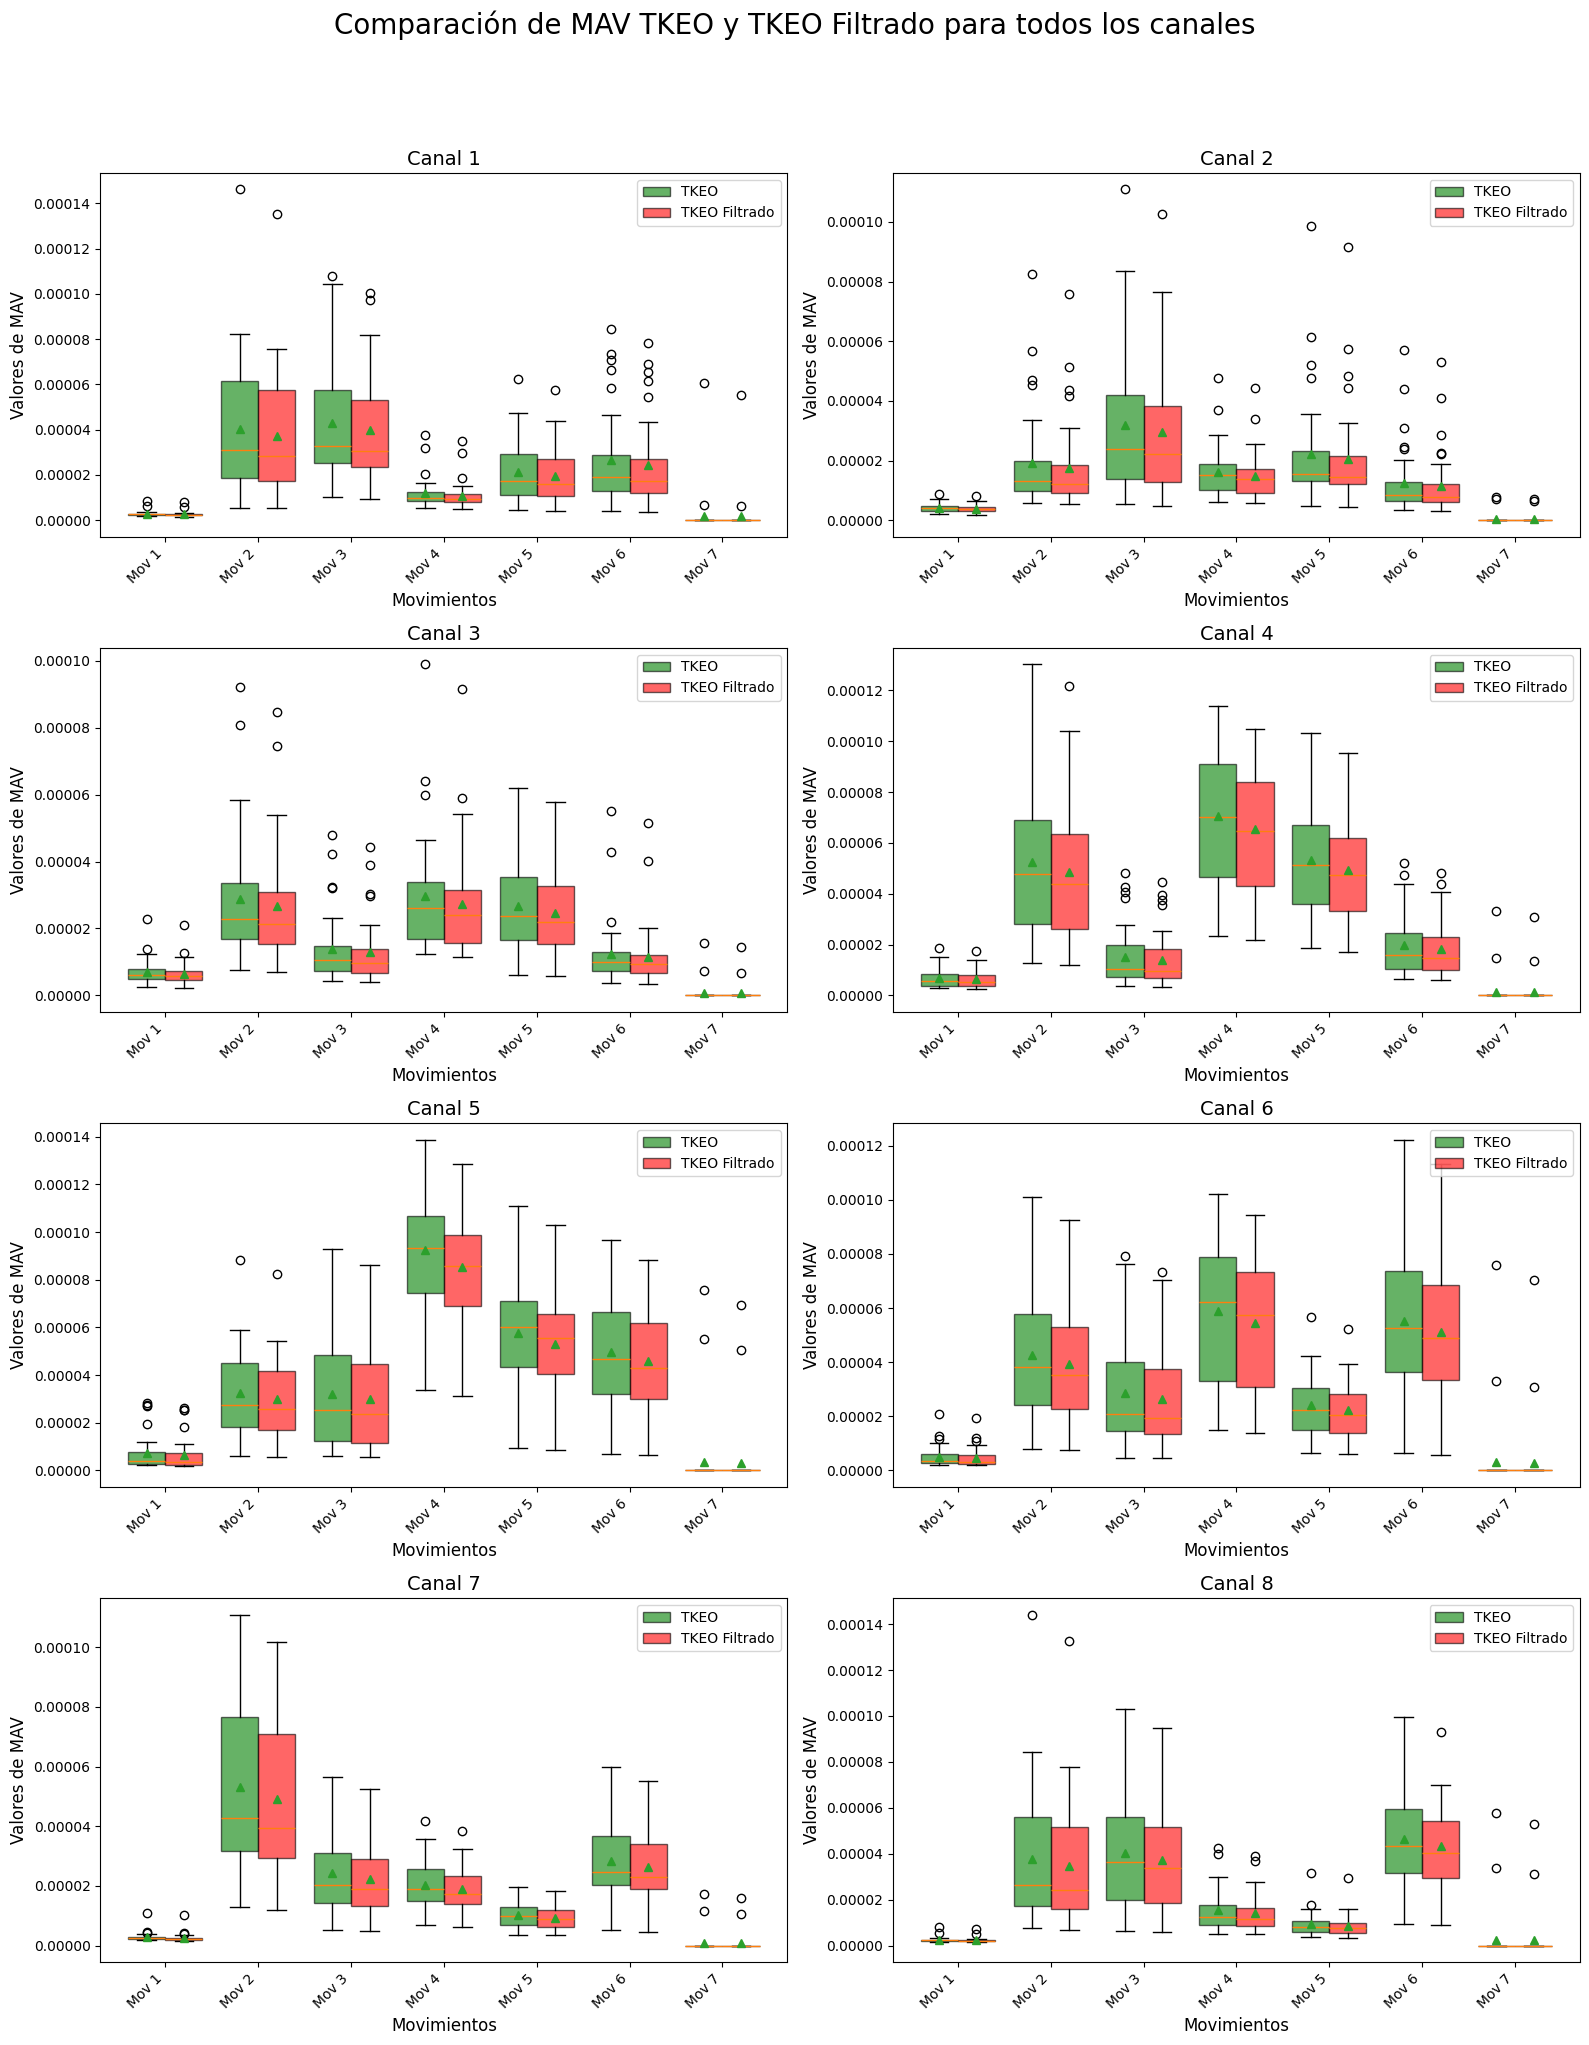

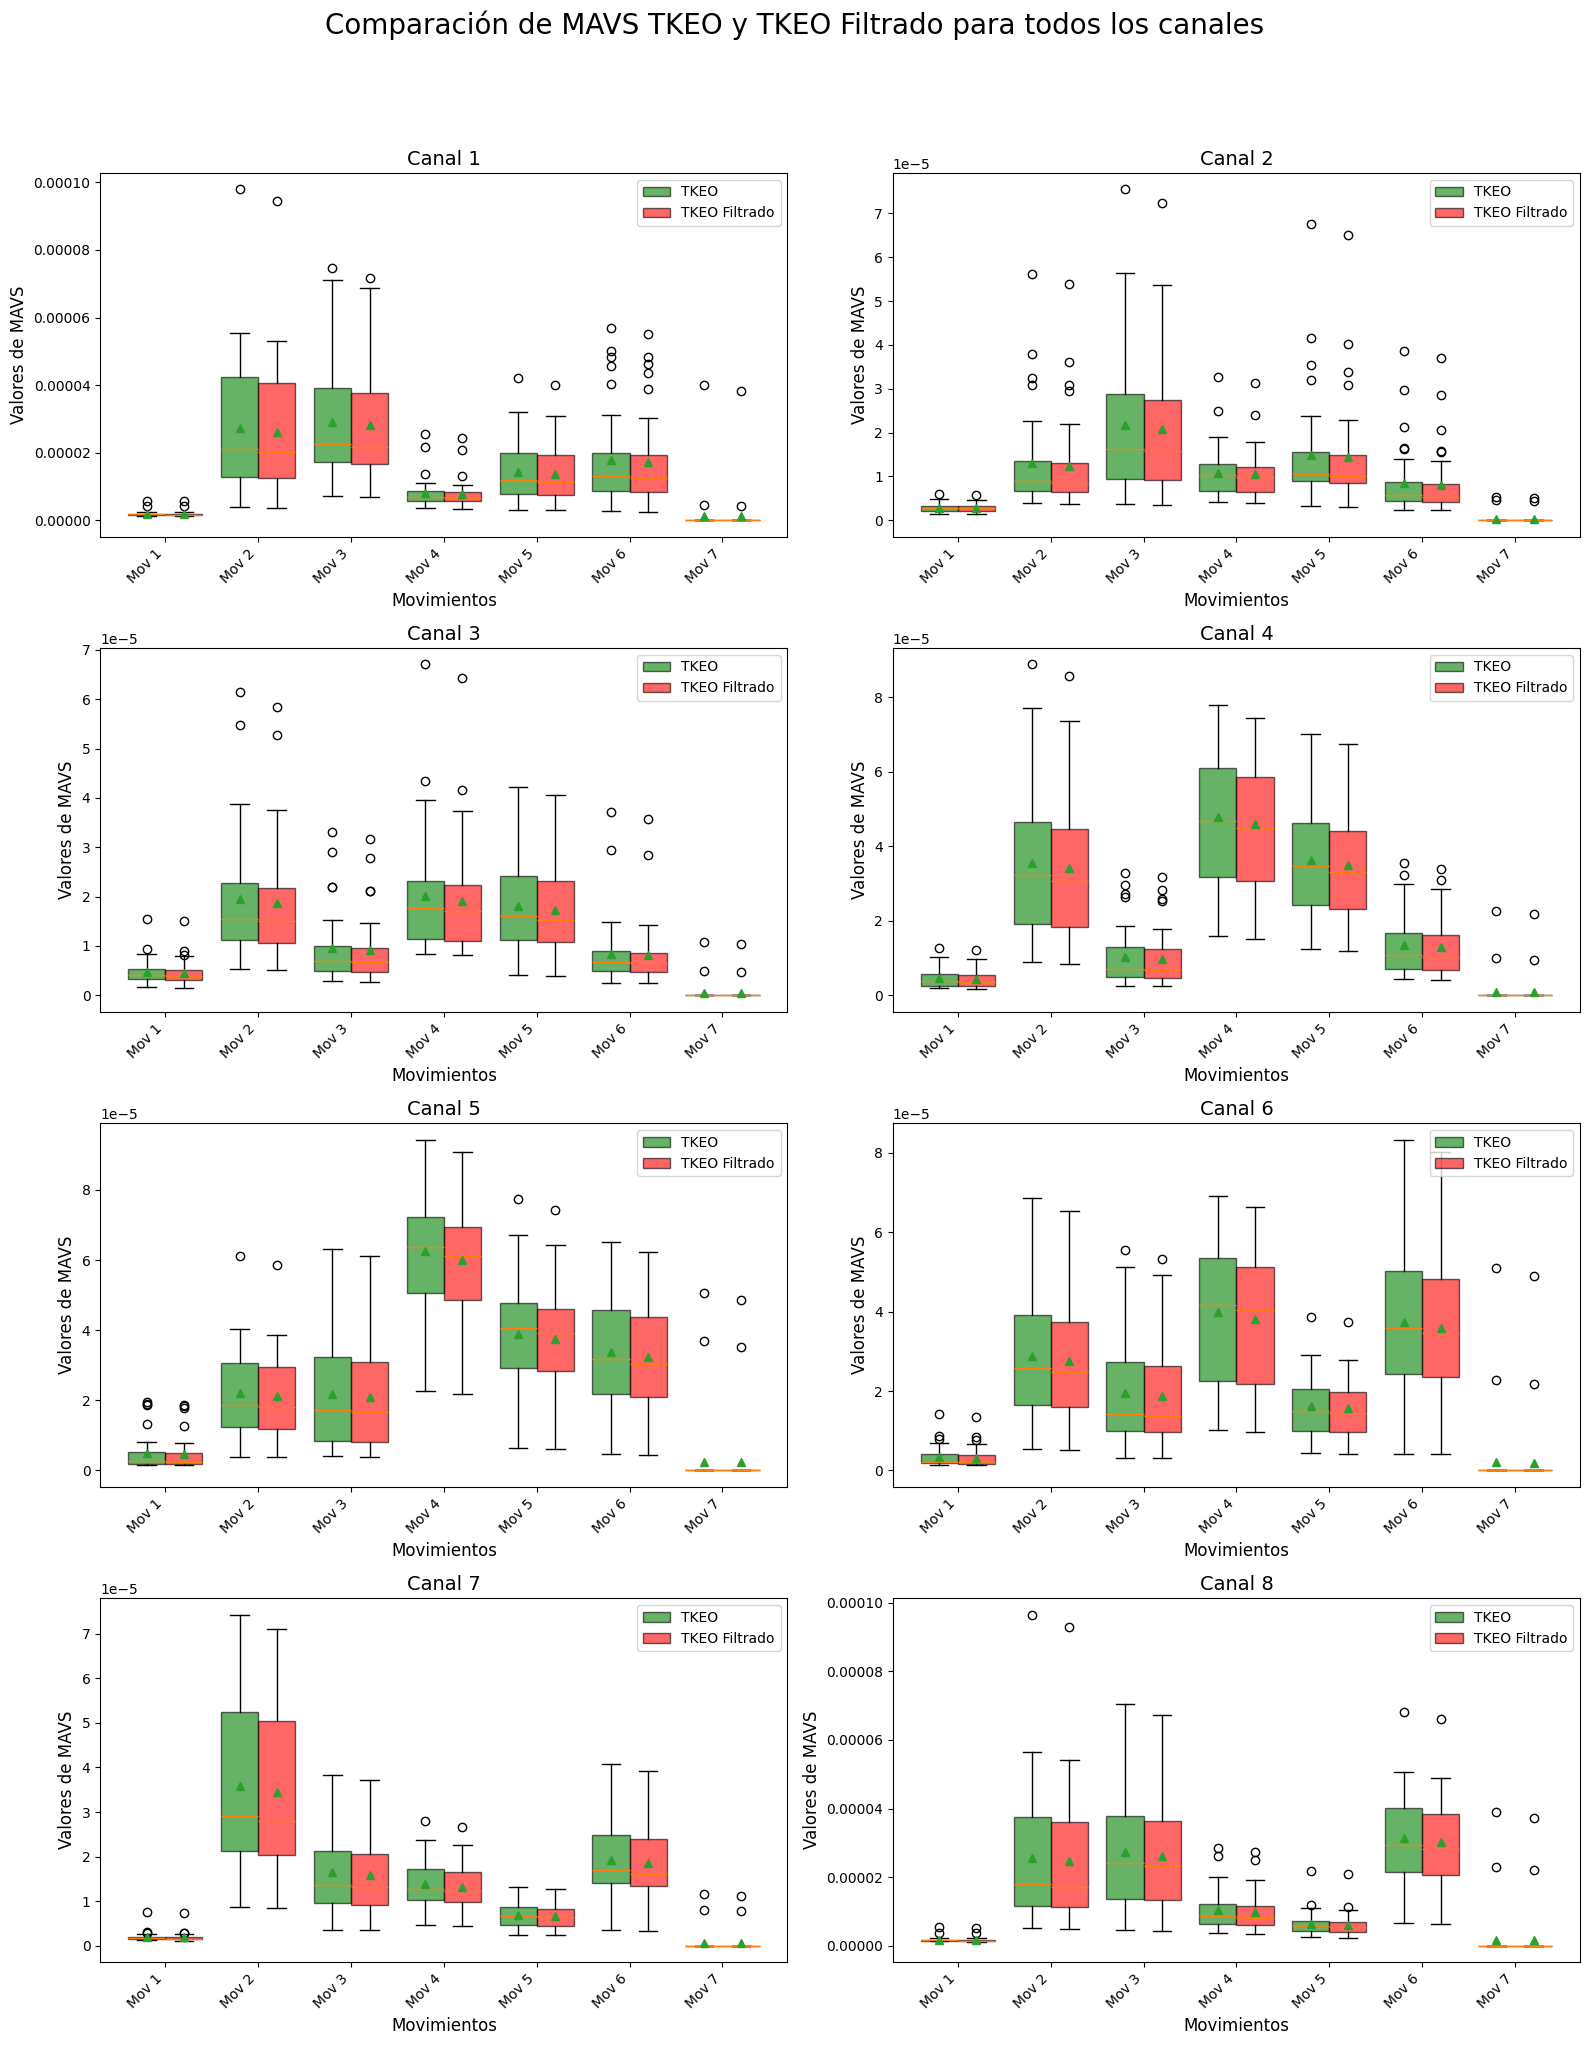

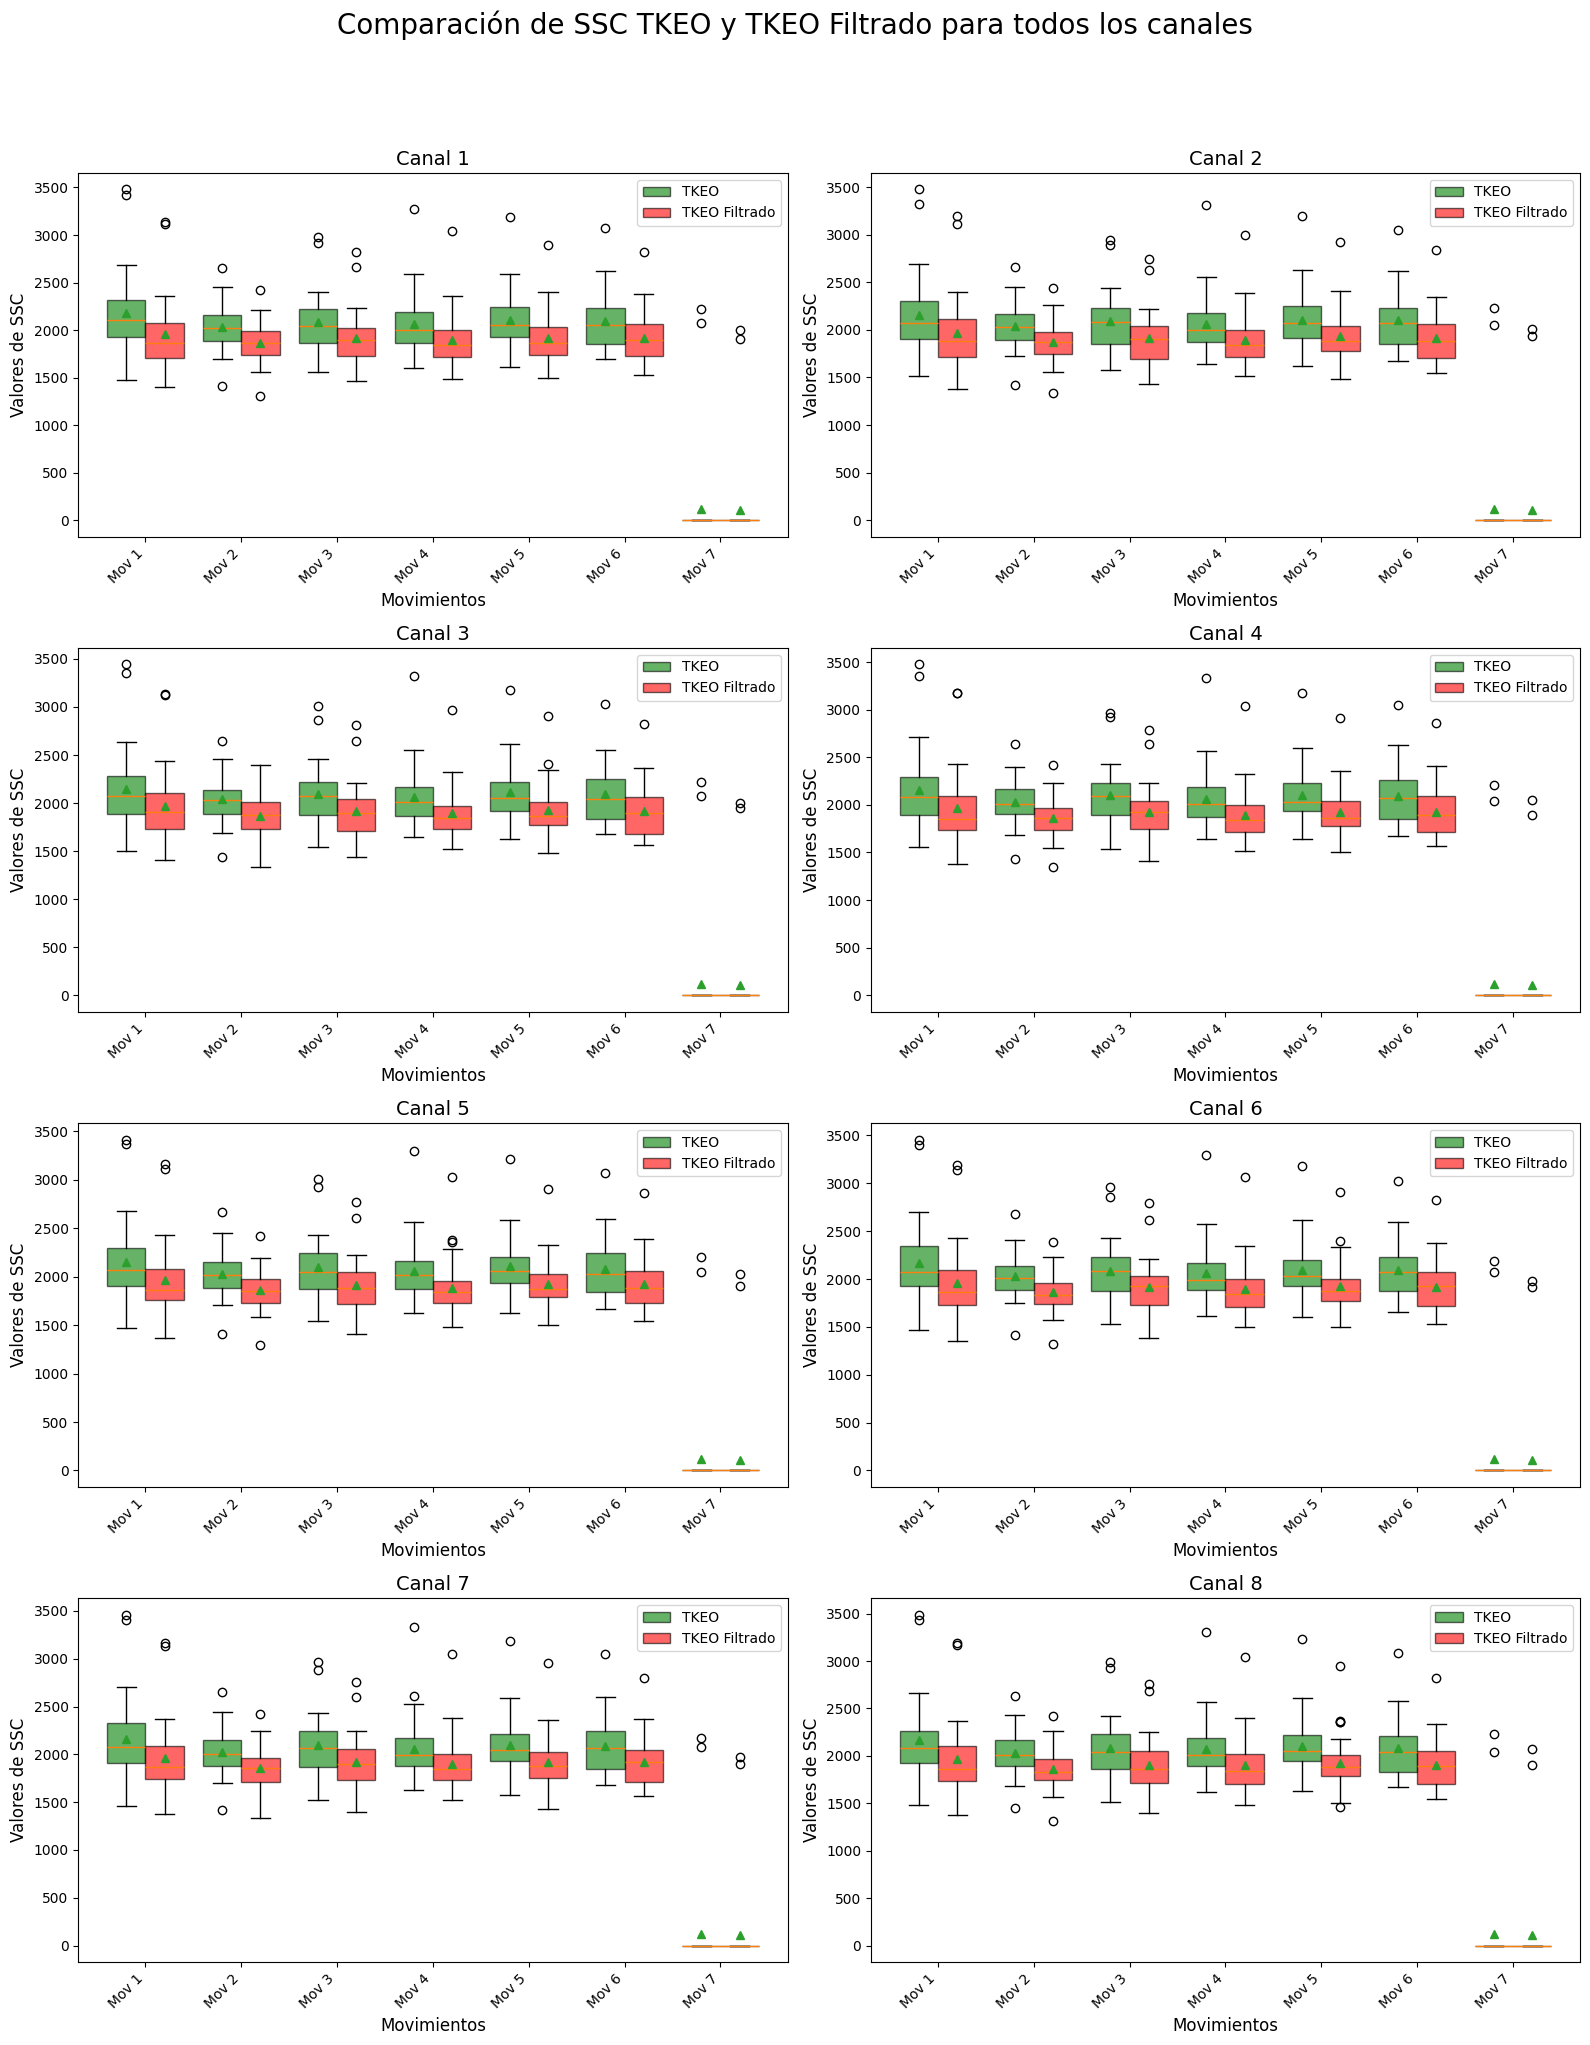

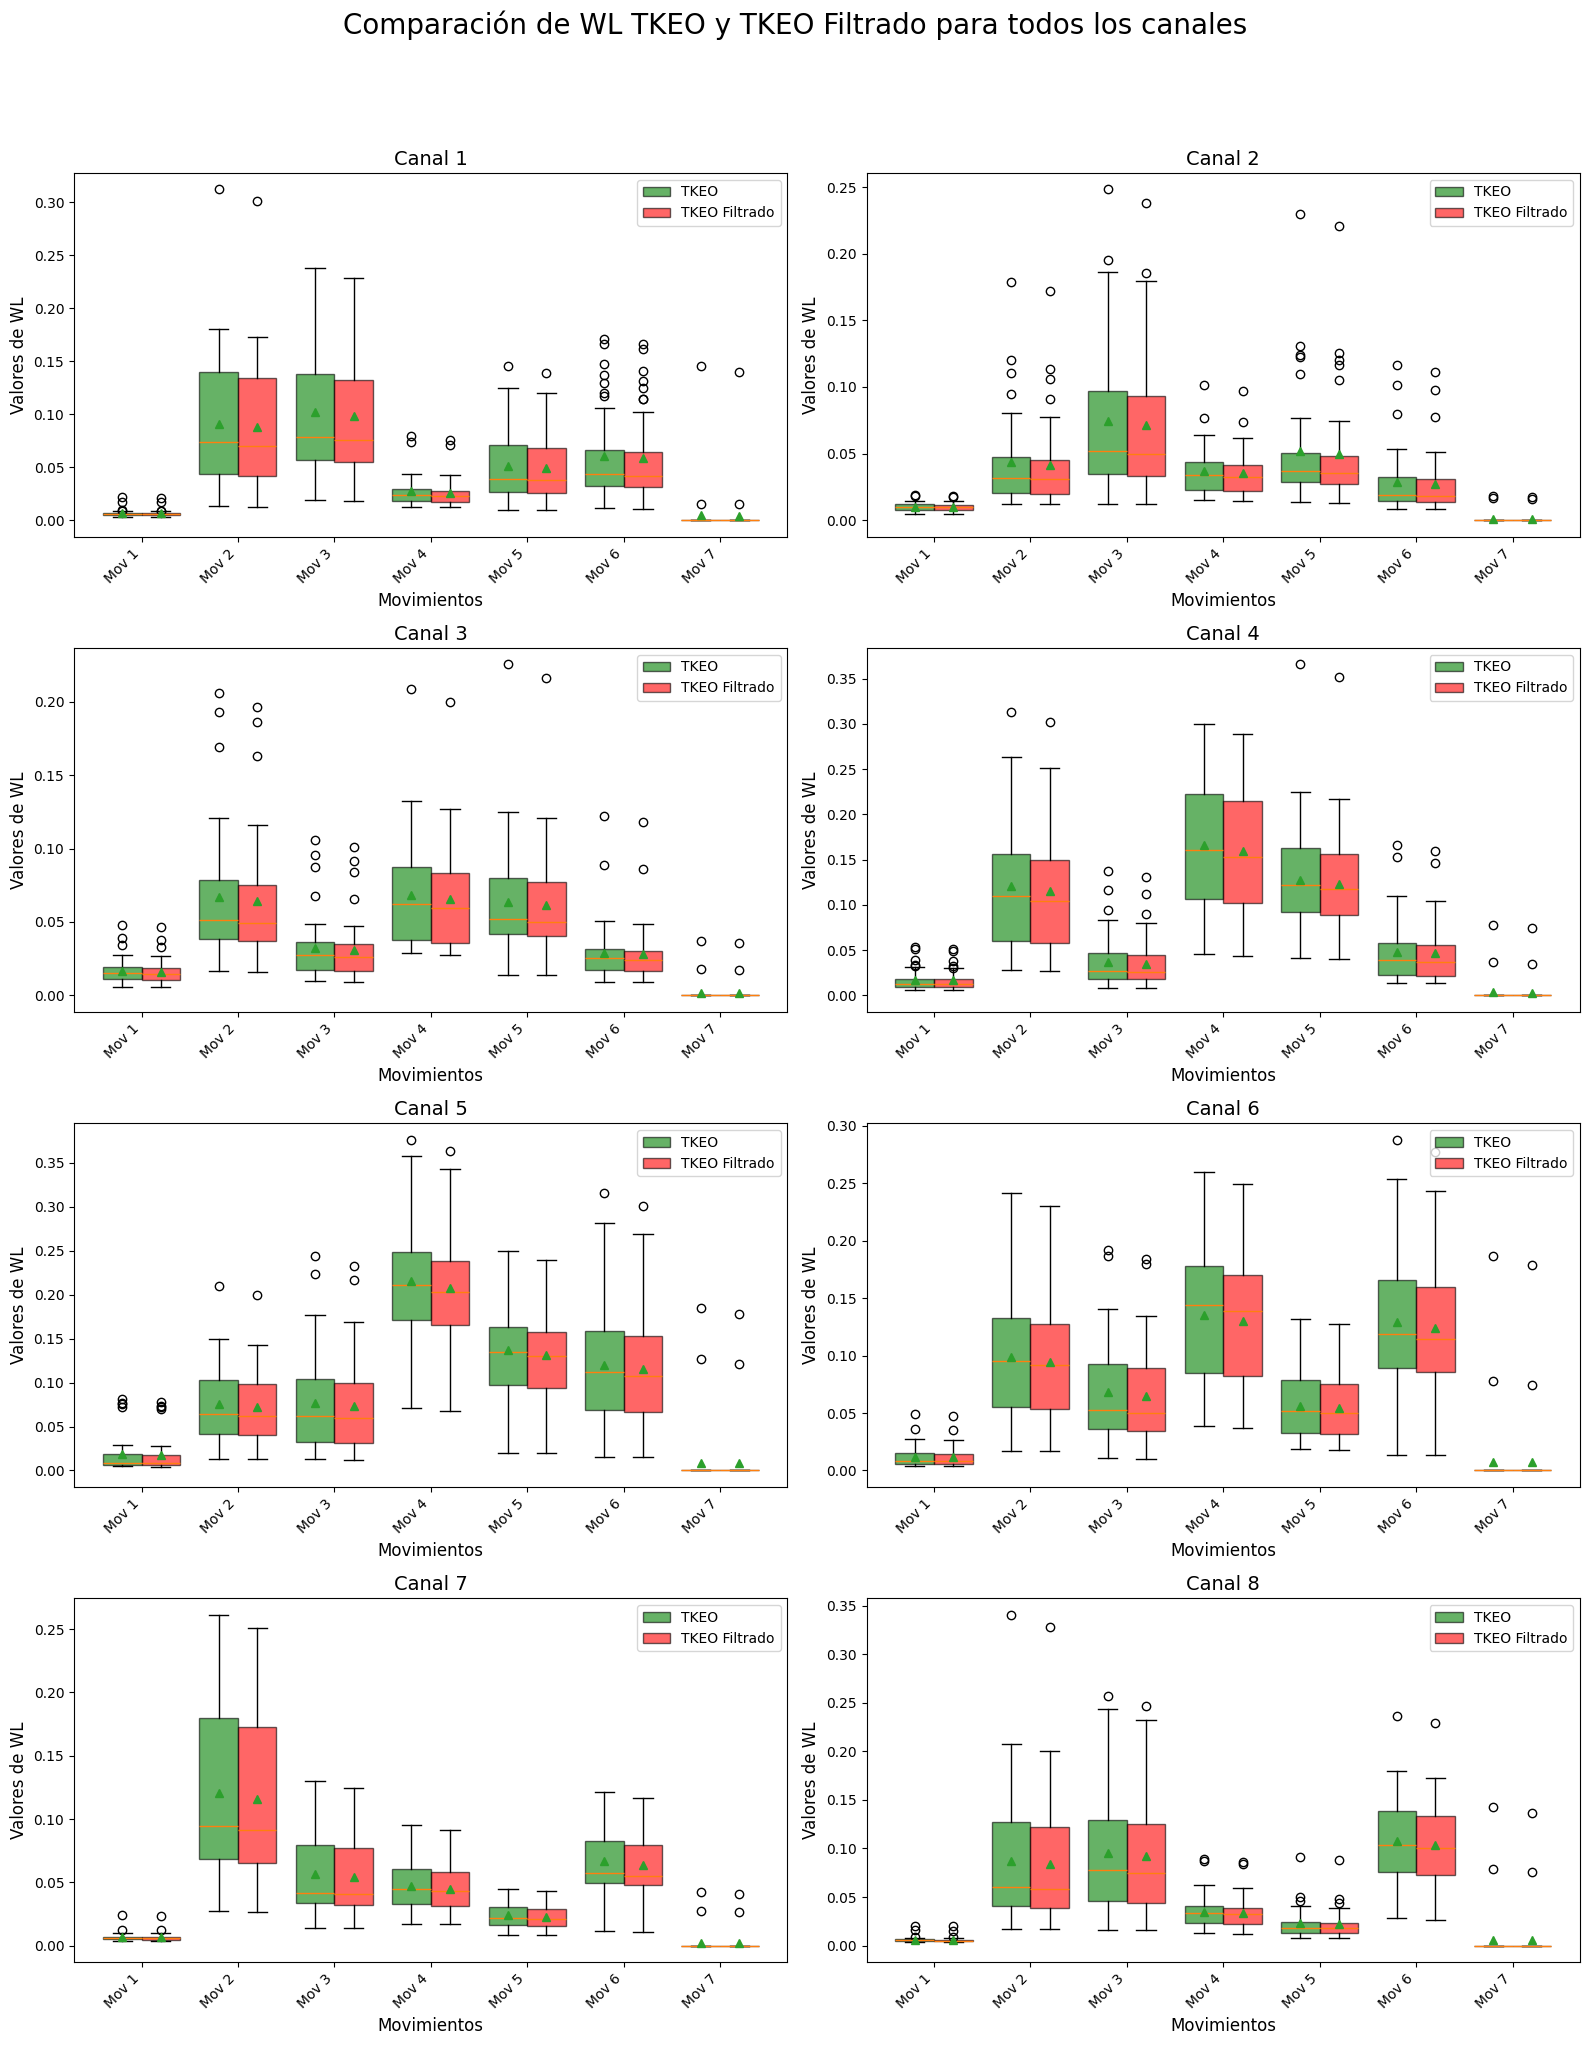

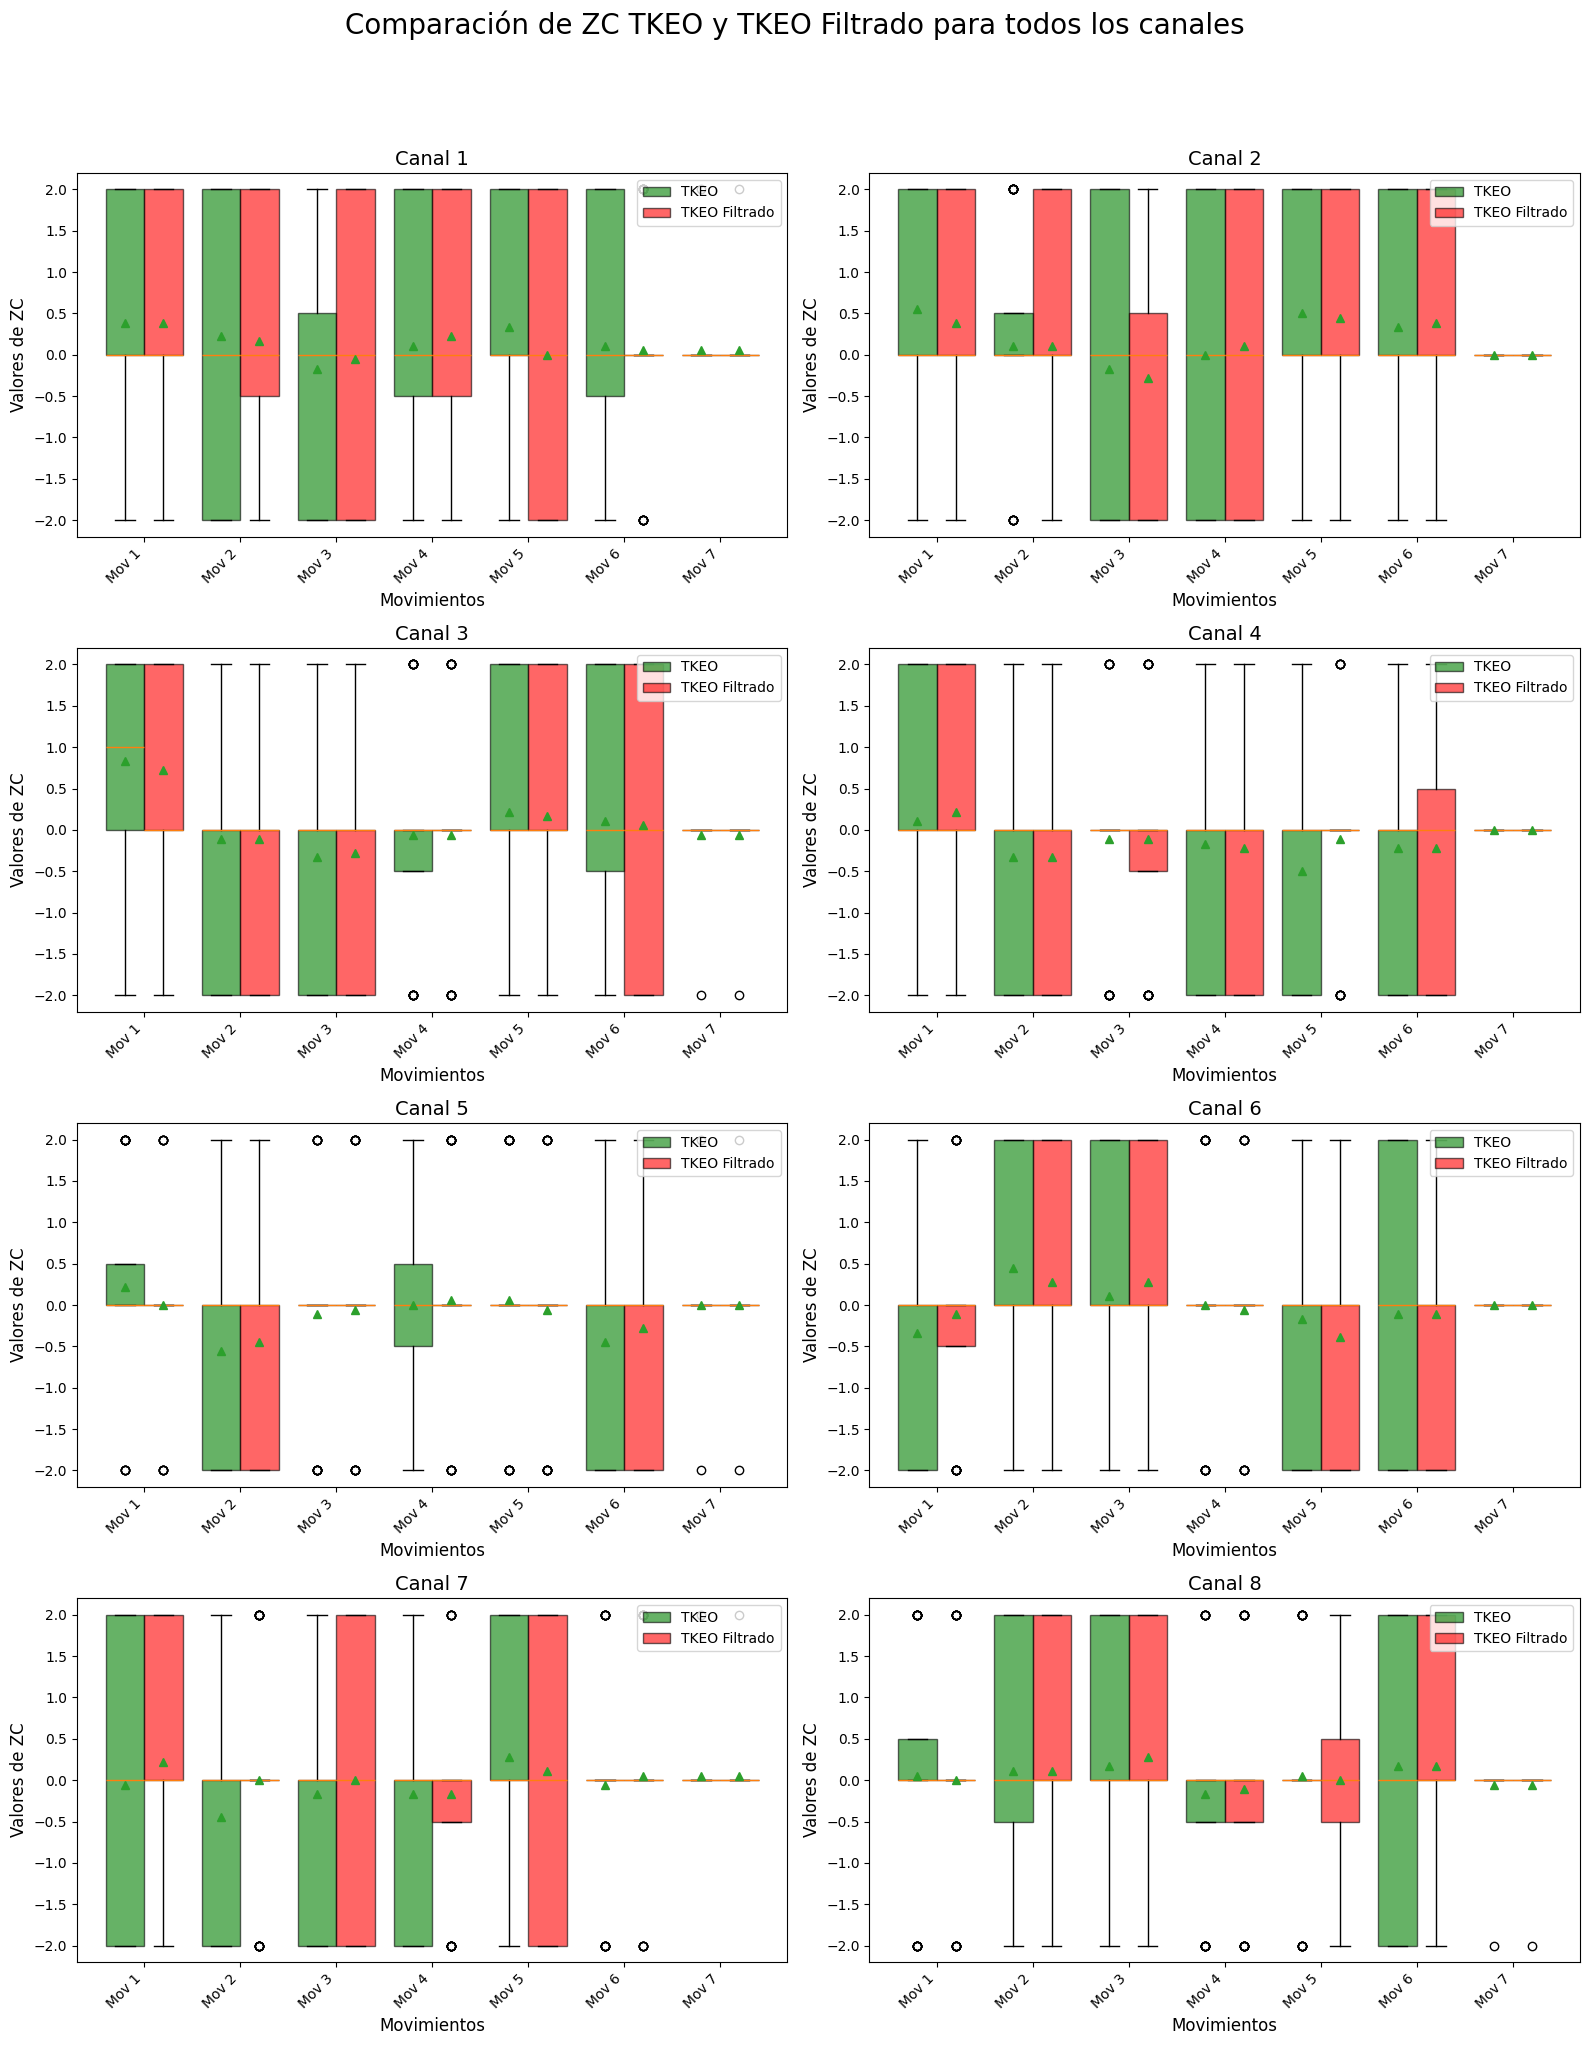

In [116]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Lista de estadísticas a graficar
estadisticas = ['RMS', 'Var', 'MAV', 'MAVS', 'SSC', 'WL', 'ZC']

# Número de movimientos (clases)
n_movimientos = 8  

# Número de canales
n_canales = 8  

# Posiciones para los boxplots
posiciones = np.arange(1, n_movimientos)  

# Colores para los boxplots
color_tkeo = 'green'
color_tkeo_filt = 'red'

# Iterar sobre cada estadística
for l in estadisticas:
    # Crear una figura y ejes para los boxplots
    fig, axs = plt.subplots(4, 2, figsize=(16, 20))  # 4 filas, 2 columnas
    fig.suptitle(f'Comparación de {l} TKEO y TKEO Filtrado para todos los canales', fontsize=20, y=1.02)

    # Iterar sobre cada canal
    for j in range(1, n_canales + 1):  
        lista_canales_tkeo = []
        lista_canales_tkeo_filt = []
        # Iterar sobre cada movimiento
        for i in np.arange(1, n_movimientos):  
            # Filtrar el DataFrame para el movimiento actual
            df_final_Tkeo_mov1 = df_final_Tkeo[df_final_Tkeo['class'] == i]
            df_final_Tkeo_filt_mov1 = df_final_Tkeo_filt[df_final_Tkeo_filt['class'] == i]
            # Obtener los valores de la estadística para el canal y movimiento actual
            lista_tkeo = np.array(df_final_Tkeo_mov1[f'{l}_{j}'])  
            lista_tkeo_filt = np.array(df_final_Tkeo_filt_mov1[f'{l}_{j}'])  
            # Agregar los valores a las listas de canales
            lista_canales_tkeo.append(lista_tkeo)
            lista_canales_tkeo_filt.append(lista_tkeo_filt)
        
        # Seleccionar el subplot apropiado
        ax = axs[(j-1) // 2, (j-1) % 2]  
        # Crear el boxplot para el canal actual con el color correspondiente
        bplot1 = ax.boxplot(lista_canales_tkeo, positions=posiciones - 0.2, widths=0.4, patch_artist=True, 
                            boxprops=dict(facecolor=color_tkeo, alpha=0.6), showmeans=True)
        bplot2 = ax.boxplot(lista_canales_tkeo_filt, positions=posiciones + 0.2, widths=0.4, patch_artist=True, 
                            boxprops=dict(facecolor=color_tkeo_filt, alpha=0.6), showmeans=True)
        # Configurar etiquetas de las posiciones en el eje x
        ax.set_xticks(posiciones)
        ax.set_xticklabels([f'Mov {i}' for i in np.arange(1, n_movimientos)], rotation=45, ha='right')

        ax.set_title(f'Canal {j}', fontsize=14)
        ax.set_xlabel('Movimientos', fontsize=12)
        ax.set_ylabel(f'Valores de {l}', fontsize=12)
        ax.legend([bplot1["boxes"][0], bplot2["boxes"][0]], ['TKEO', 'TKEO Filtrado'], loc='upper right')

    # Ajustar el layout para que el título no se solape
    plt.tight_layout(rect=[0, 0, 1, 0.98])  
    plt.show()


Después de examinar detenidamente los gráficos de cajas y bigotes que representaban tanto los datos filtrados como los no filtrados, se tenía la expectativa de detectar discrepancias significativas entre ambos conjuntos. El propósito era determinar la mejor alternativa para avanzar con la construcción de un modelo predictivo utilizando técnicas de redes neuronales y aprendizaje automático.

Sin embargo, se evidenció que las distribuciones de las variables estadísticas para ambas muestras eran notablemente similares ( incluso algunas estaban contenidas en las otras), aunque con escalas diferentes debido al proceso de filtrado. Se realizaron comparaciones entre el comportamiento de estas variables para diversos tipos de movimientos. Se concluyó que características como la Varianza (Var), la Suma de la Segunda Derivada del Cambio de Signo (SSC) y los Cruces por Cero (ZC) no mostraban discrepancias significativas entre los distintos movimientos, lo que sugería que podrían no ser idóneas para la discriminación entre ellos.

Por otro lado, se destacaron diferencias notables en ciertas variables como la Raíz Cuadrada de la Media de los Cuadrados (RMS), el Valor Absoluto Medio (MAV), el MAV de la Derivada Absoluta del Valor Medio (MAVS) y la Longitud del Camino de Onda (WL). Estas discrepancias eran evidentes tanto en los datos filtrados como en los no filtrados.

Considerando el analisis de estos datos, se determinó que sería más pertinente continuar utilizando los datos filtrados en el proyecto. Esto se fundamenta en que, aunque las distribuciones de las variables son similares, el filtrado inicial elimina el ruido y asegura que solo se emplee la información relevante en cada señal. Esta estrategia proporciona datos de entrada más precisos para el modelo, lo que potencialmente podría traducirse en una mejora en los resultados de predicción.

*Comienzo de la construccion del modelo*

Realizo la normalizacion de los datos y la visualiacion de los datos estadisticos para confirmar.

In [117]:
# Lista de la variable objetivo
target = ['class']

# Lista de variables que no se utilizarán en el modelo
trash = ['SSC', 'Var', 'ZC']

# Lista para almacenar las posiciones de las variables a descartar
lista_trash = []

# Iterar sobre las variables no deseadas y los canales
for i in trash:
    for j in np.arange(1, 9):
        # Construir el nombre de la variable
        pos = f"C_{j}{i}"
        # Agregar la posición a la lista de descartes
        lista_trash.append(pos)

# Convertir listas a conjuntos para facilitar la comparación
set_target = set(target)
set_lista_trash = set(lista_trash)

# Seleccionar las variables predictoras
predictors = list(set(df_final_Tkeo_filt.columns) - set_target - set_lista_trash)

# Ordenar las variables predictoras
predictors = [col for col in df_final_Tkeo_filt.columns if col in predictors]

# Normalizar las variables predictoras
df_final_Tkeo_filt[predictors] = df_final_Tkeo_filt[predictors] / df_final_Tkeo_filt[predictors].max()

# Mostrar estadísticas descriptivas de las variables predictoras normalizadas
df_final_Tkeo_filt[predictors].describe()


,Sujeto,RMS_1,Var_1,MAV_1,MAVS_1,SSC_1,WL_1,ZC_1,RMS_2,Var_2,...,SSC_7,WL_7,ZC_7,RMS_8,Var_8,MAV_8,MAVS_8,SSC_8,WL_8,ZC_8
count,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,...,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000
mean,0.513889,0.157190,0.053825,0.144170,0.145305,0.528350,0.156711,0.059524,0.142243,0.045778,...,0.523413,0.176815,0.019841,0.164740,0.058559,0.153915,0.154579,0.518205,0.151231,0.027778
std,0.289138,0.170974,0.110307,0.161806,0.163058,0.224985,0.173740,0.680131,0.160146,0.114441,...,0.223069,0.187433,0.646476,0.177609,0.110899,0.169975,0.170756,0.221081,0.170177,0.646183
min,0.027778,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,...,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000
25%,0.270833,0.022032,0.000485,0.020715,0.020990,0.531928,0.022808,0.000000,0.044038,0.001940,...,0.524194,0.028915,0.000000,0.021089,0.000445,0.019564,0.019907,0.519893,0.019364,0.000000
50%,0.513889,0.099398,0.009881,0.087182,0.088436,0.580140,0.092632,0.000000,0.096070,0.009229,...,0.576218,0.128574,0.000000,0.099375,0.009876,0.090502,0.091922,0.568609,0.090016,0.000000
75%,0.756944,0.228353,0.052146,0.200133,0.202307,0.640645,0.223565,1.000000,0.176867,0.031282,...,0.634409,0.246849,0.000000,0.254814,0.064930,0.233478,0.237314,0.632832,0.223727,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Aquí estamos realizando la preparación de datos para entrenar y evaluar un modelo de aprendizaje automático. Primero, seleccionamos las variables predictoras y la variable objetivo de nuestro conjunto de datos preparado, representadas por las matrices `X` y `y` respectivamente. Luego, dividimos estos datos en conjuntos de entrenamiento y prueba utilizando la función `train_test_split` de scikit-learn. Esta división se realiza con el fin de entrenar el modelo en una parte de los datos y evaluar su rendimiento en una parte independiente. Al ajustar las dimensiones de las variables objetivo para asegurar su compatibilidad con el modelo, imprimimos las dimensiones de los conjuntos de entrenamiento y prueba para verificar que estén correctamente estructurados antes de proceder con el entrenamiento del modelo.

In [118]:
# Seleccionar las variables predictoras y la variable objetivo
X = df_final_Tkeo_filt[predictors].values
y = df_final_Tkeo_filt[target].values

# Dividir los datos en conjuntos de entrenamiento y prueba
# Se utiliza la misma semilla para obtener resultados reproducibles
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, random_state=40)

# Ajustar las dimensiones de las variables objetivo
y_test = np.squeeze(y_test)
y_train = np.squeeze(y_train)

# Imprimir las dimensiones de los conjuntos de entrenamiento y prueba
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)


(151, 57)
(151,)
(101, 57)
(101,)


Verifico, además que mis Y_train tenga todos los gestos para el entrenamiento 

In [119]:
unique_classes = np.unique(y_train)
print("Valores únicos en la columna 'class' de los datos de entrenamiento:", unique_classes)

Valores únicos en la columna 'class' de los datos de entrenamiento: [1 2 3 4 5 6 7]


El siguiente código presentado realizó una validación cruzada utilizando un clasificador MLP (Perceptrón Multicapa) con regularización. Se configuró el parámetro `alpha` en 0.0001 para aplicar la regularización L2 (también conocida como decaimiento de peso) al modelo MLP. Dentro del bucle de validación cruzada, se inicializó el clasificador MLP con los parámetros especificados, se ajustó al conjunto de entrenamiento y se evaluó su rendimiento en el conjunto de prueba. Las matrices de confusión para el conjunto de prueba y entrenamiento fueron calculadas, junto con la precisión del modelo en el conjunto de prueba. Finalmente, se calcularon y visualizaron los promedios de las matrices de confusión para el conjunto de entrenamiento y prueba a lo largo de todas las iteraciones de validación cruzada. La precisión promedio del modelo después de todas las iteraciones de validación cruzada fue impresa para su análisis.

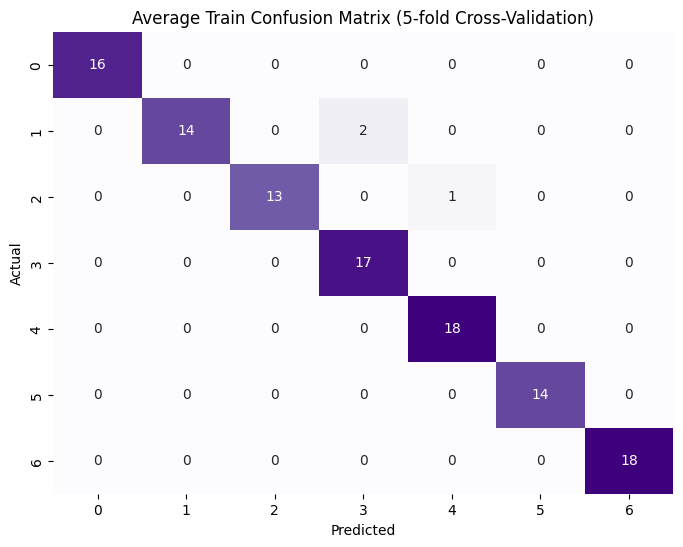

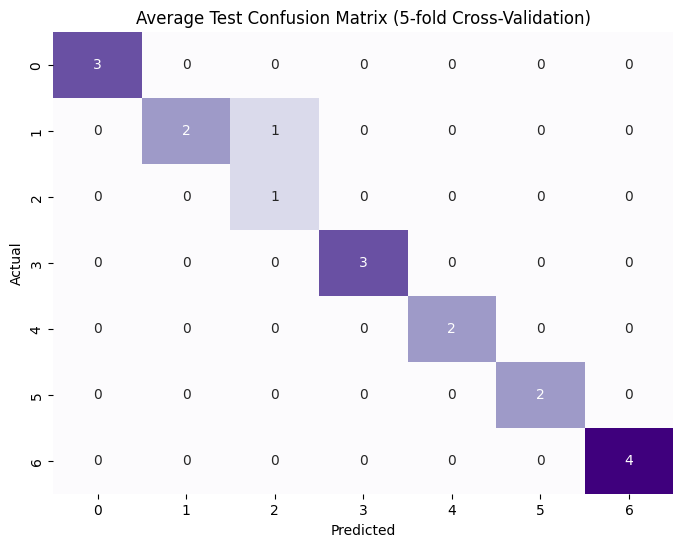

Accuracy en entrenamiento: 0.9403973509933775
Accuracy en prueba: 0.7128712871287128


In [123]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold

# Configurar la validación cruzada
kf = KFold(n_splits=5)
fold_runs = 0  # Contador de iteraciones
final_score = 0  # Puntuación final
MatrizC_train = np.zeros((7, 7))  # Matriz de confusión promedio para entrenamiento
MatrizC_test = np.zeros((7, 7))  # Matriz de confusión promedio para prueba

# Regularización (alpha)
alpha = 0.0001

# Validación cruzada
for train_i, test_i in kf.split(X_train):
    
    # Inicializar el clasificador MLP con regularización
    mlp = MLPClassifier(hidden_layer_sizes=(3,3), activation='tanh', solver='adam', max_iter=200000, alpha=alpha)
    fold_runs += 1
    mlp.fit(X_train[train_i], y_train[train_i])

    # Predecir en el conjunto de prueba y entrenamiento
    y_pred_test = mlp.predict(X_train[test_i])
    y_pred_train = mlp.predict(X_train[train_i])

    # Calcular la matriz de confusión para prueba y entrenamiento
    cm_test = confusion_matrix(y_train[test_i], y_pred_test)
    cm_train = confusion_matrix(y_train[train_i], y_pred_train)

    # Calcular la precisión del modelo en el conjunto de prueba
    outVal = mlp.score(X_train[test_i], y_train[test_i])
    final_score += outVal
    
    # Actualizar la matriz de confusión promedio para prueba y entrenamiento
    MatrizC_test[:cm_test.shape[0], :cm_test.shape[1]] += cm_test
    MatrizC_train[:cm_train.shape[0], :cm_train.shape[1]] += cm_train
    
# Calcular el promedio de la matriz de confusión para prueba y entrenamiento
MatrizC_train /= fold_runs
MatrizC_test /= fold_runs

# Calcular la precisión en entrenamiento y prueba
accuracy_train = accuracy_score(y_train, mlp.predict(X_train))
accuracy_test = accuracy_score(y_test, mlp.predict(X_test))

# Graficar la matriz de confusión promedio para entrenamiento en morado
plt.figure(figsize=(8, 6))
sns.heatmap(np.floor(MatrizC_train), annot=True, fmt="g", cmap="Purples", cbar=False)
plt.title('Average Train Confusion Matrix ({}-fold Cross-Validation)'.format(fold_runs))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Graficar la matriz de confusión promedio para prueba en morado
plt.figure(figsize=(8, 6))
sns.heatmap(np.floor(MatrizC_test), annot=True, fmt="g", cmap="Purples", cbar=False)
plt.title('Average Test Confusion Matrix ({}-fold Cross-Validation)'.format(fold_runs))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Imprimir la precisión promedio del modelo después de todas las iteraciones de validación cruzada
print('Accuracy en entrenamiento:', accuracy_train)
print('Accuracy en prueba:', accuracy_test)


El método utilizado en este caso es la búsqueda de hiperparámetros utilizando validación cruzada estratificada junto con GridSearchCV. Primero, se escalan los datos de entrenamiento utilizando StandardScaler para asegurar que todas las características tengan una escala comparable. Luego, se define un diccionario de hiperparámetros que incluye las configuraciones a explorar para el Perceptrón Multicapa (MLP), como el número de capas ocultas, la función de activación y el solucionador utilizado para ajustar los pesos de la red neuronal. A continuación, se inicializa el clasificador MLP y se realiza la búsqueda de hiperparámetros utilizando GridSearchCV para encontrar la mejor combinación de hiperparámetros. Una vez obtenido el mejor modelo MLP, se utiliza la validación cruzada estratificada (StratifiedKFold) para evaluar su desempeño en un conjunto de datos de prueba. Se calculan las matrices de confusión para el conjunto de entrenamiento y prueba, y se grafican sus promedios para visualizar el rendimiento del modelo. Finalmente, se imprime la precisión promedio del modelo después de todas las iteraciones de validación cruzada.

c:\Users\Daniel\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Daniel\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Daniel\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Daniel\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and 

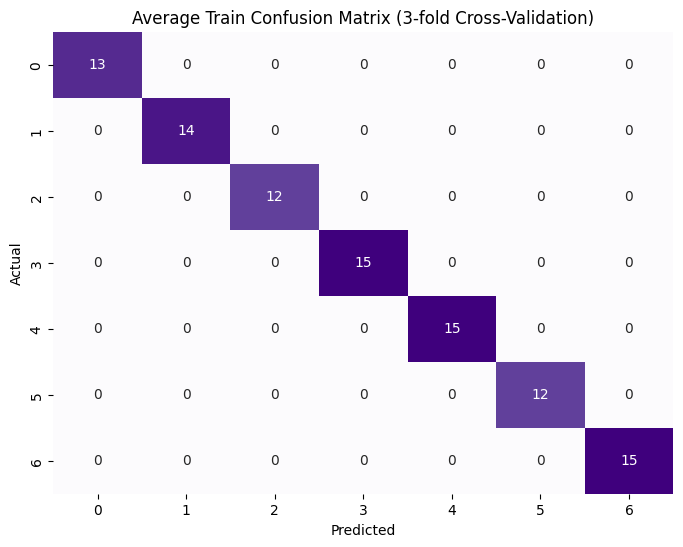

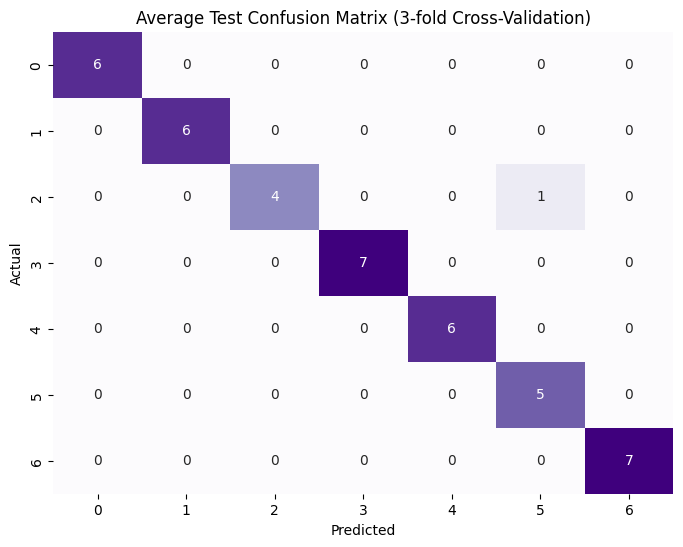

Accuracy en entrenamiento: 0.9337748344370861
Accuracy en prueba: 0.7821782178217822


In [124]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Escalar los datos de entrenamiento
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Definir el diccionario de hiperparámetros a explorar
param_grid = {
    'hidden_layer_sizes': [(8,10), (8, 8), (10,10), (10, 10)],
    'activation': ['tanh', 'relu'],
    'solver': ['adam', 'sgd']
}

# Inicializar el clasificador MLP
mlp = MLPClassifier(max_iter=2000)

# Realizar la búsqueda de hiperparámetros utilizando GridSearchCV
grid_search = GridSearchCV(estimator=mlp, param_grid=param_grid, cv=3)
grid_search.fit(X_train_scaled, y_train)

# Obtener el mejor modelo MLP
mlp_best = grid_search.best_estimator_

# Definir el método de validación cruzada estratificada
kf = StratifiedKFold(n_splits=3)
fold_runs = 0
final_score = 0
MatrizC_train = np.zeros((7, 7))
MatrizC_test = np.zeros((7, 7))

# Iterar sobre las particiones de entrenamiento y prueba
for train_i, test_i in kf.split(X_train_scaled, y_train):
    X_train_fold, X_test_fold = X_train_scaled[train_i], X_train_scaled[test_i]
    y_train_fold, y_test_fold = y_train[train_i], y_train[test_i]
    
    # Entrenar el modelo MLP
    mlp_best.fit(X_train_fold, y_train_fold)
    
    # Realizar predicciones
    y_pred_test = mlp_best.predict(X_test_fold)
    y_pred_train = mlp_best.predict(X_train_fold)
    
    # Calcular matrices de confusión
    cm_test = confusion_matrix(y_test_fold, y_pred_test)
    cm_train = confusion_matrix(y_train_fold, y_pred_train)
    
    # Calcular precisión
    outVal = mlp_best.score(X_test_fold, y_test_fold)
    final_score += outVal
    
    # Acumular matrices de confusión
    MatrizC_test += cm_test
    MatrizC_train += cm_train
    
    fold_runs += 1

# Calcular matrices de confusión promedio
MatrizC_train /= fold_runs
MatrizC_test /= fold_runs

# Graficar la matriz de confusión promedio para entrenamiento
plt.figure(figsize=(8, 6))
sns.heatmap(np.floor(MatrizC_train), annot=True, fmt="g", cmap="Purples", cbar=False)
plt.title('Average Train Confusion Matrix ({}-fold Cross-Validation)'.format(fold_runs))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Graficar la matriz de confusión promedio para prueba
plt.figure(figsize=(8, 6))
sns.heatmap(np.floor(MatrizC_test), annot=True, fmt="g", cmap="Purples", cbar=False)
plt.title('Average Test Confusion Matrix ({}-fold Cross-Validation)'.format(fold_runs))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Calcular la precisión en entrenamiento y prueba
accuracy_train = accuracy_score(y_train, mlp_best.predict(X_train_scaled))
accuracy_test = accuracy_score(y_test, mlp_best.predict(scaler.transform(X_test)))

# Imprimir precisión promedio
print('Accuracy en entrenamiento:', accuracy_train)
print('Accuracy en prueba:', accuracy_test)


`mlp_best` se refiere al mejor estimador encontrado durante la búsqueda de hiperparámetros utilizando GridSearchCV. Es decir, es el modelo de Perceptrón Multicapa (MLP) con la combinación óptima de hiperparámetros que maximiza el rendimiento en los datos de entrenamiento según la validación cruzada realizada. Este modelo se utiliza posteriormente para hacer predicciones en nuevos datos.

In [126]:
mlp_best

MLPClassifier(activation='tanh', hidden_layer_sizes=(10, 10), max_iter=2000,
              solver='sgd')

El siguiente código implementa un modelo de **Random Forest** utilizando el clasificador `RandomForestClassifier` de scikit-learn. El modelo se entrena y evalúa utilizando una técnica de **Validación Cruzada con K-Folds** (KFold), con 6 divisiones en este caso.

Dentro del bucle de validación cruzada, se inicializa el modelo RandomForestClassifier con ciertos hiperparámetros, como el número de árboles (`n_estimators`) inicialmente de 250, el criterio de división (`criterion`), el número máximo de características a considerar en cada división (`max_features`), entre otros.

Luego, el modelo se ajusta al conjunto de datos de entrenamiento y se utilizan las predicciones para calcular las matrices de confusión tanto para el conjunto de entrenamiento como para el de prueba. Estas matrices se acumulan a lo largo de todas las iteraciones de validación cruzada.

Finalmente, se calcula la matriz de confusión promedio para el conjunto de entrenamiento y para el de prueba, y se visualiza mediante mapas de calor. Además, se imprime el puntaje de precisión promedio del modelo después de todas las iteraciones de validación cruzada.

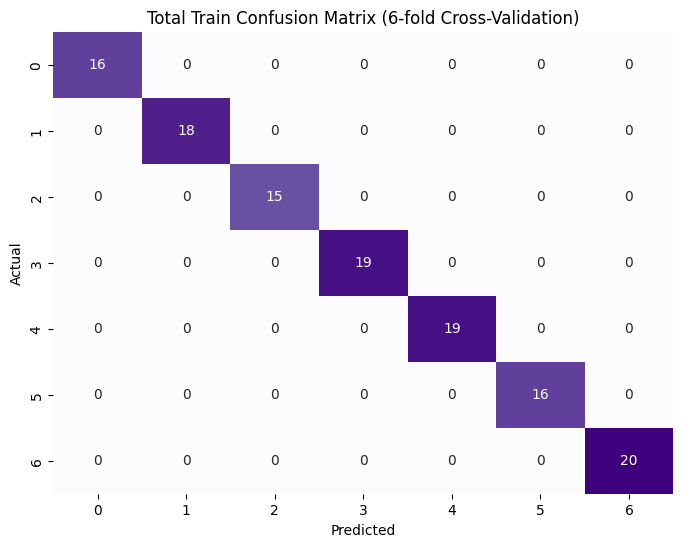

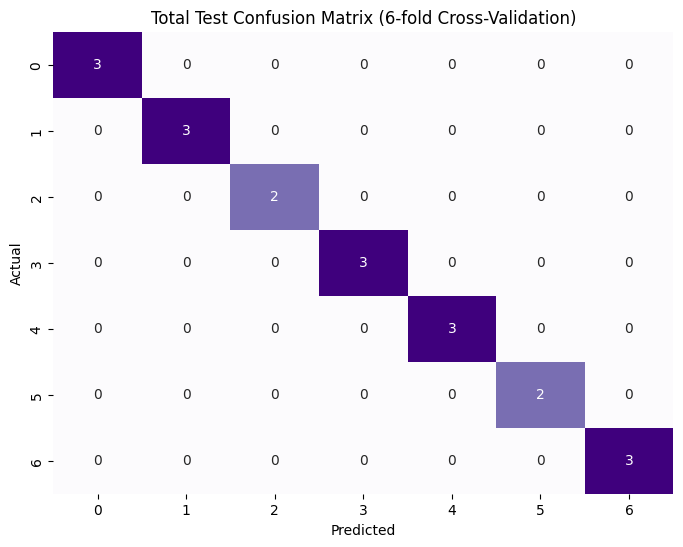

Accuracy en entrenamiento: 0.9602649006622517
Accuracy en prueba: 0.801980198019802


In [129]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración de la validación cruzada con 6 divisiones
kf = KFold(n_splits=6)
fold_runs = 0  # Seguimiento de las iteraciones
final_score = 0  # Puntaje final
total_cm_train = np.zeros((7, 7), dtype=int)  # Matriz de confusión para el conjunto de entrenamiento
total_cm_test = np.zeros((7, 7), dtype=int)  # Matriz de confusión para el conjunto de prueba

# Se realiza la validación cruzada nuevamente debido al tamaño pequeño del conjunto de datos
for train_i, test_i in kf.split(X_train):
    # Se utiliza el modelo RandomForestClassifier
    modelo = RandomForestClassifier(n_estimators=250, criterion='gini', max_features=4, oob_score=True, n_jobs=-1, random_state=123)
    fold_runs += 1
    modelo.fit(X_train[train_i], y_train[train_i])

    # Predicciones en los conjuntos de prueba y entrenamiento
    y_pred_test = modelo.predict(X_train[test_i])
    y_pred_train = modelo.predict(X_train[train_i])

    # Cálculo de las matrices de confusión
    cm_test = confusion_matrix(y_train[test_i], y_pred_test)
    cm_train = confusion_matrix(y_train[train_i], y_pred_train)

    # Cálculo del puntaje de precisión para el conjunto de prueba
    outVal = modelo.score(X_train[test_i], y_train[test_i])
    final_score += outVal

    # Acumulación de las matrices de confusión
    total_cm_test += cm_test
    total_cm_train += cm_train

# Cálculo de las matrices de confusión promedio
total_cm_train = np.floor_divide(total_cm_train, fold_runs)
total_cm_test = np.floor_divide(total_cm_test, fold_runs)

# Visualización de la matriz de confusión promedio para el conjunto de entrenamiento
plt.figure(figsize=(8, 6))
sns.heatmap(total_cm_train, annot=True, fmt="d", cmap="Purples", cbar=False)
plt.title('Total Train Confusion Matrix ({}-fold Cross-Validation)'.format(fold_runs))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Visualización de la matriz de confusión promedio para el conjunto de prueba
plt.figure(figsize=(8, 6))
sns.heatmap(total_cm_test, annot=True, fmt="d", cmap="Purples", cbar=False)
plt.title('Total Test Confusion Matrix ({}-fold Cross-Validation)'.format(fold_runs))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Calcular la precisión en entrenamiento y prueba
accuracy_train = accuracy_score(y_train, modelo.predict(X_train))
accuracy_test = accuracy_score(y_test, modelo.predict(X_test))

# Impresión del puntaje de precisión promedio
print('Accuracy en entrenamiento:', accuracy_train)
print('Accuracy en prueba:', accuracy_test)


Decidimos modificar el código original para reducir la cantidad de árboles en el modelo RandomForestClassifier de 250 a 100. Esto se realizó con el objetivo de explorar cómo la disminución en el número de árboles afectaría el desempeño del modelo en términos de precisión y matrices de confusión. El número de divisiones en la validación cruzada se mantuvo en 6 para garantizar una evaluación robusta del modelo en un conjunto de datos pequeño. Tras la modificación, volvimos a ejecutar el código y analizamos las matrices de confusión promedio y la precisión del modelo en el conjunto de prueba. Los resultados se presentan a continuación.

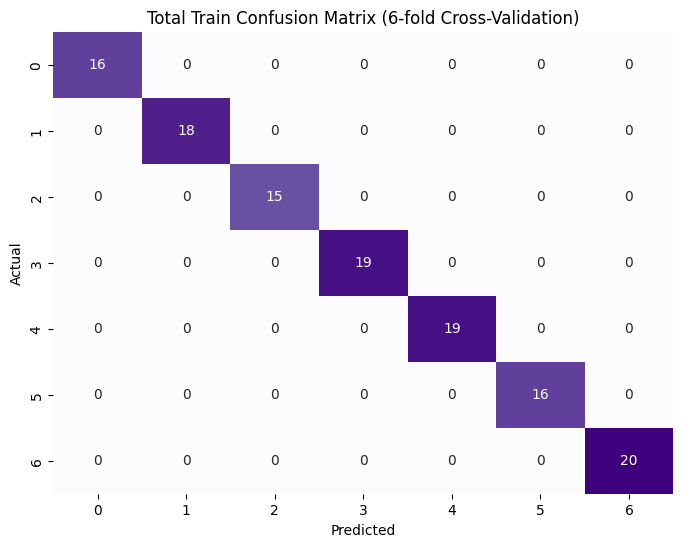

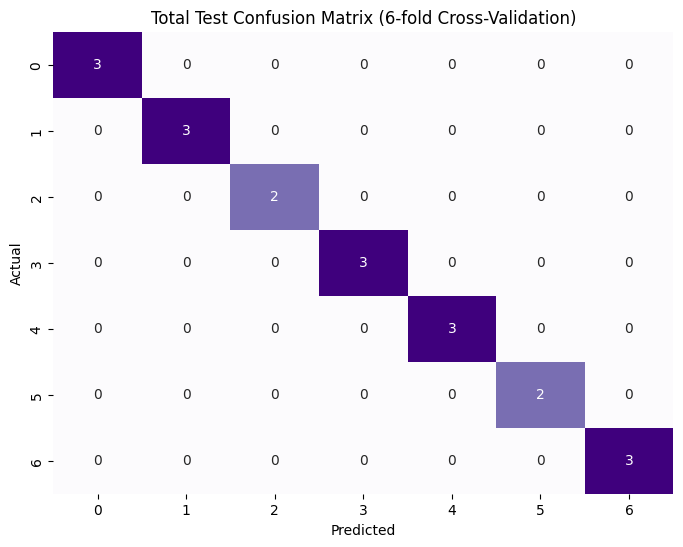

Accuracy en entrenamiento: 0.9536423841059603
Accuracy en prueba: 0.7821782178217822


In [132]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración de la validación cruzada con 6 divisiones
kf = KFold(n_splits=6)
fold_runs = 0  # Seguimiento de las iteraciones
final_score = 0  # Puntaje final
total_cm_train = np.zeros((7, 7), dtype=int)  # Matriz de confusión para el conjunto de entrenamiento
total_cm_test = np.zeros((7, 7), dtype=int)  # Matriz de confusión para el conjunto de prueba

# Se realiza la validación cruzada nuevamente debido al tamaño pequeño del conjunto de datos
for train_i, test_i in kf.split(X_train):
    # Se utiliza el modelo RandomForestClassifier
    modelo = RandomForestClassifier(n_estimators=100, criterion='gini', max_features=4, oob_score=True, n_jobs=-1, random_state=123)
    fold_runs += 1
    modelo.fit(X_train[train_i], y_train[train_i])

    # Predicciones en los conjuntos de prueba y entrenamiento
    y_pred_test = modelo.predict(X_train[test_i])
    y_pred_train = modelo.predict(X_train[train_i])

    # Cálculo de las matrices de confusión
    cm_test = confusion_matrix(y_train[test_i], y_pred_test)
    cm_train = confusion_matrix(y_train[train_i], y_pred_train)

    # Cálculo del puntaje de precisión para el conjunto de prueba
    outVal = modelo.score(X_train[test_i], y_train[test_i])
    final_score += outVal

    # Acumulación de las matrices de confusión
    total_cm_test += cm_test
    total_cm_train += cm_train

# Cálculo de las matrices de confusión promedio
total_cm_train = np.floor_divide(total_cm_train, fold_runs)
total_cm_test = np.floor_divide(total_cm_test, fold_runs)

# Visualización de la matriz de confusión promedio para el conjunto de entrenamiento
plt.figure(figsize=(8, 6))
sns.heatmap(total_cm_train, annot=True, fmt="d", cmap="Purples", cbar=False)
plt.title('Total Train Confusion Matrix ({}-fold Cross-Validation)'.format(fold_runs))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Visualización de la matriz de confusión promedio para el conjunto de prueba
plt.figure(figsize=(8, 6))
sns.heatmap(total_cm_test, annot=True, fmt="d", cmap="Purples", cbar=False)
plt.title('Total Test Confusion Matrix ({}-fold Cross-Validation)'.format(fold_runs))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Calcular la precisión en entrenamiento y prueba
accuracy_train = accuracy_score(y_train, modelo.predict(X_train))
accuracy_test = accuracy_score(y_test, modelo.predict(X_test))

# Impresión del puntaje de precisión promedio
print('Accuracy en entrenamiento:', accuracy_train)
print('Accuracy en prueba:', accuracy_test)


El análisis comparativo entre dos modelos de Random Forests entrenados con diferentes números de árboles evidenció que el modelo con 250 árboles alcanzó una precisión ligeramente superior en comparación con el modelo que utilizó solo 100 árboles. A pesar de esta mejora, la diferencia en precisión no resultó significativa, especialmente considerando que el modelo con 250 árboles consumió menos de la mitad de los recursos computacionales. Los resultados finales muestran que el primer modelo logró un rendimiento de precisión en el conjunto de entrenamiento del 96.03% y del 80.20% en el conjunto de prueba, mientras que el segundo modelo alcanzó un 95.36% de precisión en entrenamiento y un 78.22% en prueba. Estos hallazgos subrayan la importancia crítica de validar tanto el método como el modelo con los parámetros suministrados, ya que incluso pequeñas diferencias pueden impactar en el rendimiento final del modelo. Este proceso de validación es esencial para garantizar que el modelo sea robusto y generalizable a nuevos datos.

*g. (15%) Discutir cómo se podría implementar la solución del punto e y f usando sistemas embebidos seleccionando el tipo de microcontrolador (5%) y los posibles tiempos de adquisición y clasificación de las señales (10%)*

Para implementar la solución del punto e y f utilizando sistemas embebidos, necesitaríamos seleccionar un microcontrolador adecuado y considerar los posibles tiempos de adquisición y clasificación de las señales. Aquí hay una propuesta:

*Selección del tipo de microcontrolador:*
Para esta aplicación, sería prudente elegir un microcontrolador con suficiente potencia de procesamiento y capacidad de entrada/salida para manejar la adquisición de señales EMG y la ejecución de los algoritmos de clasificación de gestos en tiempo real. Algunos microcontroladores populares para aplicaciones embebidas incluyen:

-Arduino: El Arduino se utiliza como microcontrolador, el cual hace interfaz entre el ordenador y otro dispositivo, este ejecuta una determinada tarea que se le da por medio de un programa que se encuentra en el ordenador, y traduce esta tarea en una acción y viceversa, debido a los sensores y actuadores.
Los arduinos suelen ser utilizados por la fácilidad de usoy amplio conocimiento sobre estos, puede ser Arduino Uno, Arduino Nano o Arduino Mega.

- PIC: Si bien se considera que los microcontroladores PIC son de un uso más complejo, también son eficientes, al tener un largo tiempo en el mercado, es fácil acceder a distintos programas, sin embargo es posible que no se tenga la potencia suficiente para ejecutar programas más complejos.

- Microcontroladores MSP430:Tienen muy bajo consumo de energia, sin embargo su rendimiento y potencia no son tan altos.

-Microcontroladores AVR:tiene facilidad de uso, utiliza una memoria Flash en chip para almacenar la memoria de los programas. Su arquitectura RISC peromiten que tenga un alto rendimiento y un bajo consumo de energía, son populares por su eficienci ay capacidad de procesamiento.

-Microcontroladores ARM Cortex-M: Los modelos de ARM Cortex-M cono el STM32 y el ESP32, suelen ser muy utilizados debido a que tienen un buen rendimiento al mismo tiempo de eficiencia energetico, por lo tanto en caso de hacer una aplicación enbebida que requiera el procesamiento en tiempo real es muy buena opción.

Para el caso de este proyecto se llega a la conclusión que si se desea realizar por medio de un sistema embebido, un microcontrolador de modelo ARM Cortex-M, seria una buena opción por lo anteriormente mencionado, además se observa que en la bibliografia, en los proyectos en el cual se hace un análisis de gestos, estos son comunmente usados.

Por ejemplo en proyectos como Implementación de aplicaciones Deep Learning en microcontroladoresARM Cortex- en el cual se considera el ESP32 para obtener las señales y entrenar el modelo[4]. En el trabajo de Sistema de control basado en la detección de gestos de los dedos [5], en el cual se utiliza tambien el ESP32, debido a su capacidad de memoria y procesamiento, en el cual dan todas sus especificaciones. Por último en un sistema de Control de un sistema de información para bomberos mediante gestos de la mano, se considero el uso de este tipo de microcontrolador ESP32 con doble nucleo para adquirir la señal por medio de un guante [6].


*Posibles tiempos de adquisición y clasificación de señales:*
Los tiempos de adquisición y clasificación de señales dependerán de varios factores, incluyendo la frecuencia de muestreo de las señales EMG, la complejidad de los algoritmos de clasificación y la capacidad de procesamiento del microcontrolador.

1. *Adquisición de señales:* Para una señal electromiografica una frecuencia de muestreo de 1000 Hz para así capturar componentes de frecuencia en la señal hasta los 500 Hz, es decir, aplicando el teorema de Nyquist, esto hace que se capture los gestos con mayor precisión, teniendo en cuenta que los tiempos de adquisición por gesto puede estar en milisegundos o seguntos, en este caso dependera tambien de la capacidad del microcontrolador seleccionado.

2. *Clasificación de señales:* La clasificación de gestos cuando se usa algoritmos de aprendizaje automático requieren diferentes tiempos de procesamiento dependiendo de la complejidad del modelo, si es un algoritmo simple, o si se trata de redes neuronales como en este caso, la cantidad de características extraídas de la señal, el número de sensores utilizados para obtener la señal y la capacidad de reloj del microcontrolador usado. Cuando se habla de sistemas embebidos, los tiempos en de la clasificación pueden llegar a varias de segundos hasta milisegundos, dependiendo del tamaño de las caracteristicas musculares al realizar el gesto que entrean al programa.




### Referencias

[1] Tang, S., Dunnmon, J. A., Liangqiong, Q., Saab, K. K., Baykaner, T., Lee-Messer, C., & Rubin, D. L. (2023, June). Modeling multivariate biosignals with graph neural networks and structured state space models. In Conference on Health, Inference, and Learning (pp. 50-71). PMLR.

[2] Mohanty, M., & Palo, H. (2018). Machine Learning: An Effective Technique in Bio-Medical Signal Analysis and Classification. International Journal of Machine Learning and Networked Collaborative Engineering, 1(01), 1-8.

[3] David, Belo., João, Rodrigues., João, R., Vaz., João, R., Vaz., João, R., Vaz., Pedro, Pezarat-Correia., Hugo, Gamboa. (2017). Biosignals learning and synthesis using deep neural networks. Biomedical Engineering Online,  doi: 10.1186/S12938-017-0405-0.

[4] Caesarendra, W., Hishamuddin, T. A., Lai, D. T. C., Husaini, A., Nurhasanah, L., Glowacz, A., & Alfarisy, G. A. F. (2022). An embedded system using convolutional neural network model for online and real-time ECG signal classification and prediction. Diagnostics, 12(4), 795.